# HR Analytics

Ashley O'Mahony | [ashleyomahony.com](http://ashleyomahony.com) | February 2019  

***

## Introduction

### Objectives

This case study aims to model the probability of attrition of each employee from the HR Analytics Dataset, [available on Kaggle](https://www.kaggle.com/lnvardanyan/hr-analytics). Its conclusions will allow the management to understand which factors urge the employees to leave the company and which changes should be made to avoid their departure.

All the files of this project are saved in a [GitHub repository](https://github.com/ashomah/HR-Analytics).

### Libraries

This project uses a set of libraries for data manipulation, plotting and modelling.

In [1]:
# Loading Libraries
import pandas as pd #Data Manipulation
import numpy as np #Data Manipulation

import matplotlib.pyplot as plt #Plotting
import seaborn as sns #Plotting
sns.set(style='white')

from sklearn import preprocessing #Preprocessing

from scipy.stats import skew, boxcox_normmax #Preprocessing
from scipy.special import boxcox1p #Preprocessing

from sklearn.model_selection import train_test_split #Train/Test Split
from sklearn.linear_model import LogisticRegression #Model

from sklearn.metrics import classification_report #Metrics
from sklearn.metrics import confusion_matrix #Metrics
from sklearn.metrics import accuracy_score #Metrics
from sklearn.metrics import roc_auc_score, roc_curve #ROC
from sklearn import model_selection #Cross Validation
from sklearn.feature_selection import RFE, RFECV #Feature Selection

### Data Loading

The dataset is stored in the [GitHub repository](https://github.com/ashomah/HR-Analytics) as a CSV file: `turnover.csv`. The file is loaded directly from the repository.

In [2]:
# Reading Dataset from GitHub repository
hr = pd.read_csv('https://raw.githubusercontent.com/ashomah/HR-Analytics/master/assets/data/turnover.csv')
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


---

## Data Preparation

### Variables Types and Definitions

The first stage of this analysis is to describe the dataset, understand the meaning of variable and perform the necessary adjustments to ensure that the data will be proceeded correctly during the Machine Learning process.

In [3]:
# Shape of the data frame
print('Rows:', hr.shape[0], '| Columns:', hr.shape[1])

Rows: 14999 | Columns: 10


In [4]:
# Describe each variable
def df_desc(df):
    import pandas as pd
    desc = pd.DataFrame({'dtype': df.dtypes,
                         'NAs': df.isna().sum(),
                         'Numerical': (df.dtypes != 'object') & (df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() != len(df)),
                         'Boolean': df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() == len(df),
                         'Categorical': df.dtypes == 'object',
                        })
    return desc

df_desc(hr)

,dtype,NAs,Numerical,Boolean,Categorical
satisfaction_level,float64,0,True,False,False
last_evaluation,float64,0,True,False,False
number_project,int64,0,True,False,False
average_montly_hours,int64,0,True,False,False
time_spend_company,int64,0,True,False,False
Work_accident,int64,0,False,True,False
left,int64,0,False,True,False
promotion_last_5years,int64,0,False,True,False
sales,object,0,False,False,True
salary,object,0,False,False,True


The dataset consists in 14,999 rows and 10 columns. Each row represents an employee, and each column contains one employee attribute. None of these attributes contains any NA. Two (2) of these attributes contain decimal numbers, three (3) contain integers, three (3) contain booleans, and two (2) contain categorical values.

In [5]:
# Summarize numercial variables
hr.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [6]:
# Lists values of categorical variables
categories = {'sales': hr['sales'].unique().tolist(),
 'salary':hr['salary'].unique().tolist()}
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1] :print("\n")

salary:
['low', 'medium', 'high']


sales:
['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD']


The variable `sales` seems to represent the company departments. Thus, it will be renamed as `department`.

In [7]:
# Rename variable sales
hr = hr.rename(index=str, columns={'sales':'department'})

The dataset contains 10 variables with no NAs:

- `satisfaction_level`: numerical, decimal values between 0 and 1.  
  *Employee satisfaction level, from 0 to 1.*
  
  
- `last_evaluation`: numerical, decimal values between 0 and 1.  
  *Employee last evaluation score, from 0 to 1.*


- `number_project`: numerical, integer values between 2 and 7.  
  *Number of projects handled by the employee.*


- `average_montly_hours`: numerical, integer values between 96 and 310.  
  *Average monthly hours worked by the employee.*
  
  
- `time_spend_company`: numerical, integer values between 2 and 10.  
  *Number of years spent in the company by the employee.*
  
  
- `Work_acident`: encoded categorical, boolean.  
  *Flag indicating if the employee had a work accident.*
  
  
- `left`: encoded categorical, boolean.  
  *Flag indicating if the employee has left the company. This is the __target variable__ of the study, the one to be modelled.*
  
  
- `promotion_last_5years`: encoded categorical, boolean.  
  *Flag indicating if the employee has been promoting within the past 5 years.*


- `department`: categorical, 10 values. 
  *Department of the employee: Sales, Accounting, HR, Technical, Support, Management, IT, Product Management, Marketing, R&D.*
  
  
- `salary`: categorical, 3 values.  
  *Salary level of the employee: Low, Medium, High.*

### Exploratory Data Analysis

#### Target Proportion

The objective of this study is to build a model to predict the value of the variable `left`, based on the other variables available.

In [8]:
# Count occurences of each values in left
hr['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

**23.8% of the employees listed in the dataset have left the company.**  

The dataset is not balanced, which might introduce some bias in the predictive model. It would be interesting to proceed to two (2) analyses, one with the imbalanced dataset and one with a dataset balanced using the Synthetic minority Oversampling Technique (SMOTE).

A closer look to the means of the variables allow to highlight the differences between the employees who left the company and those who stayed.

In [9]:
# Get the mean of each variable for the different values of left
hr.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


Employees who left the company have:
- **a lower satisfaction level:** 0.44 vs 0.67.
- **higher average monthly working hours:** 207 vs 199.
- **a lower work accident ratio:** 0.05 vs 0.18.
- **a lower promotion rate:** 0.01 vs 0.03.

#### Correlation Analysis

A correlation analysis will allow to identify relationships between the dataset variables. A plot of their distributions highlighting the value of the target variable might also reveal some patterns.

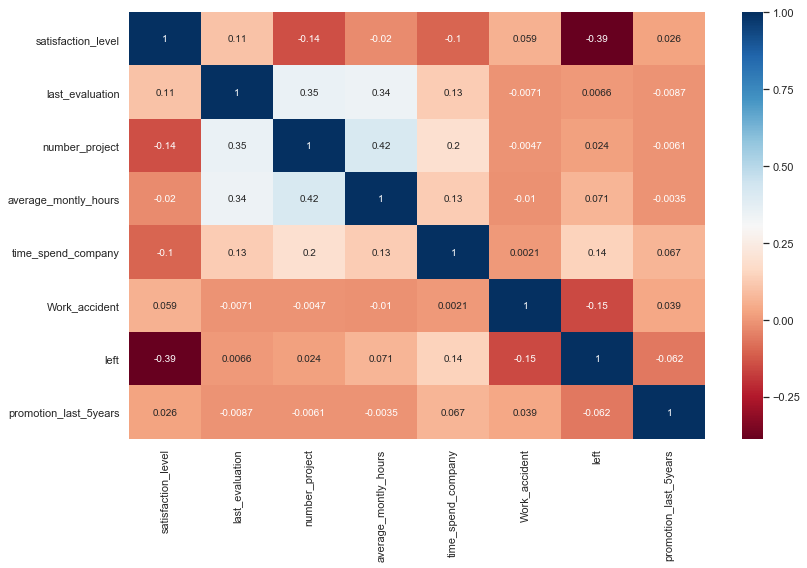

In [10]:
# Correlation Matrix
plt.figure(figsize=(12,8))
sns.heatmap(hr.corr(), cmap='RdBu', annot=True)
plt.tight_layout()

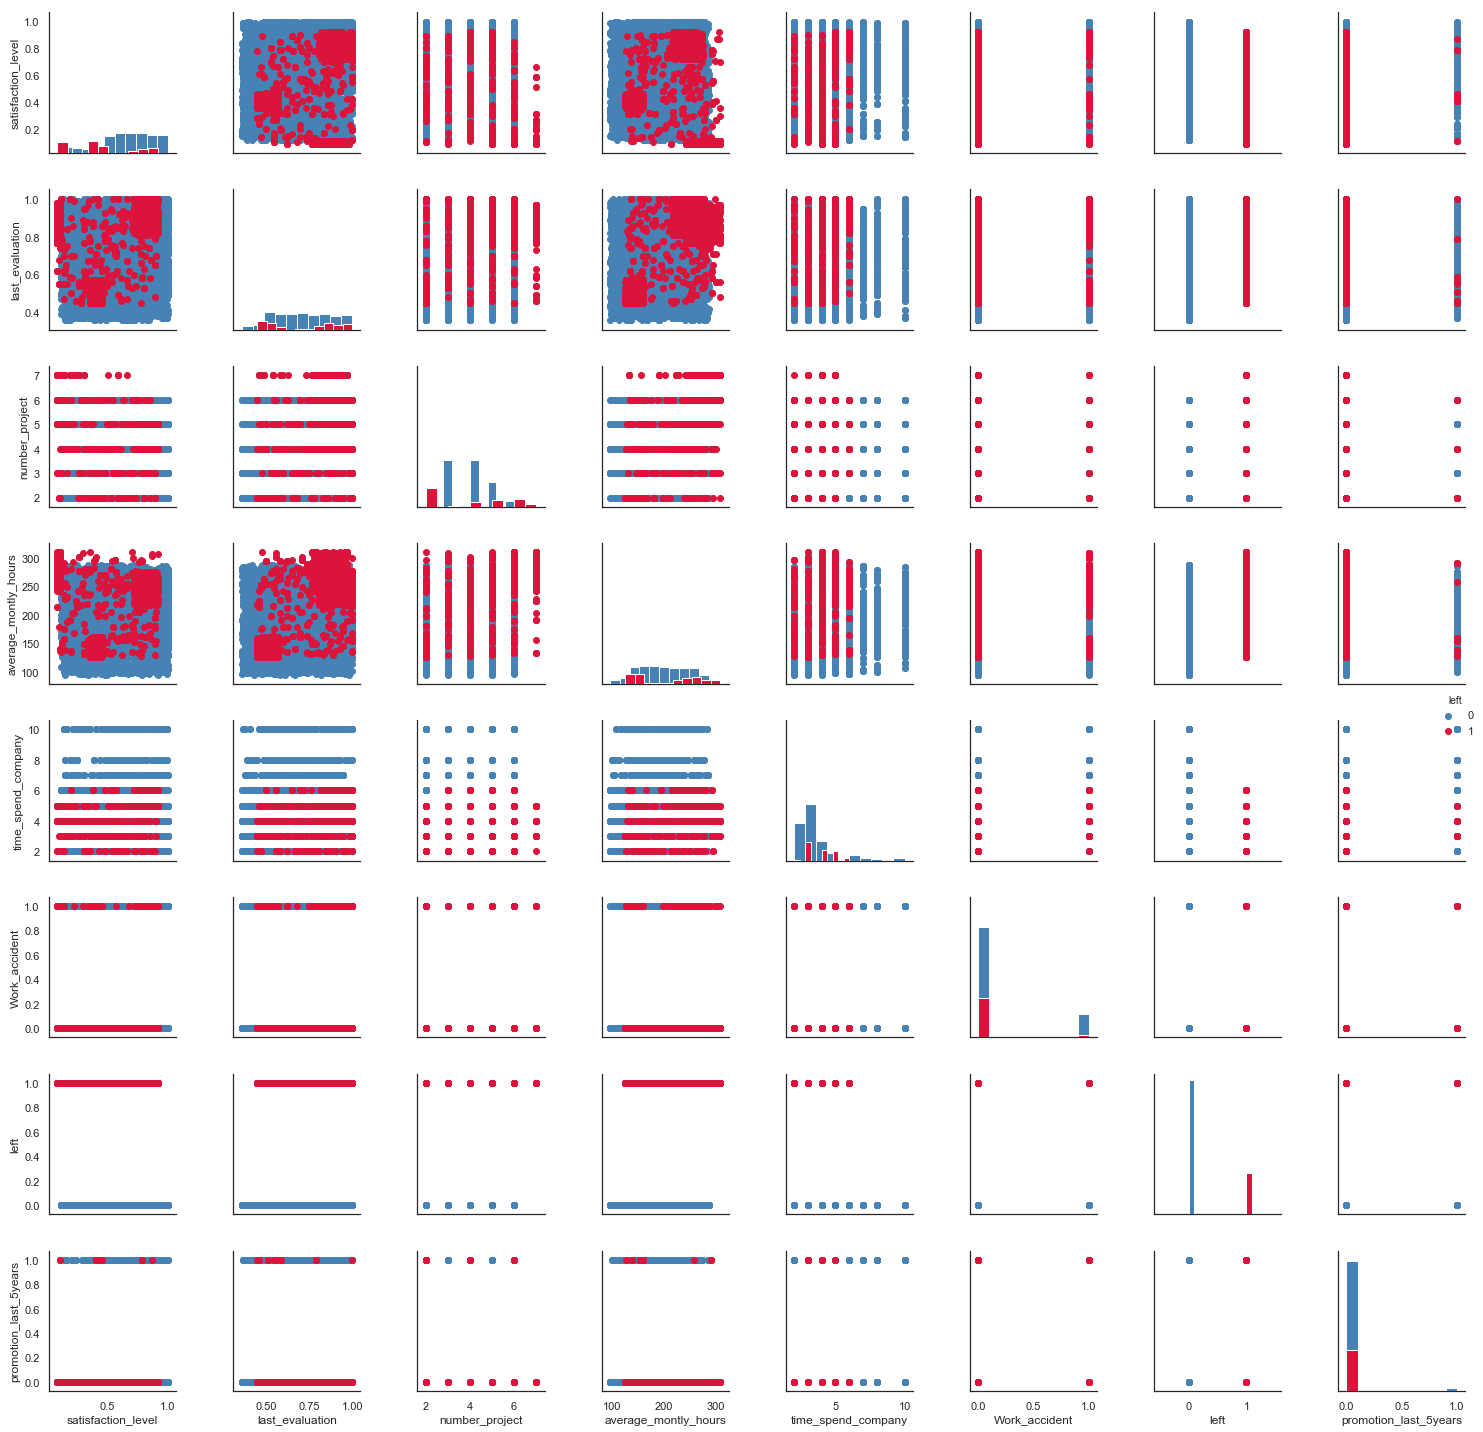

In [11]:
# Pair Plot
plot = sns.PairGrid(hr, hue='left', palette=('steelblue', 'crimson'))
plot = plot.map_diag(plt.hist)
plot = plot.map_offdiag(plt.scatter)
plot.add_legend()
plt.tight_layout()

No strong correlation appears in the dataset. However:
- `number_project` and `average_monthly_hours` have a **moderate positive** correlation (0.42).
- `left` and `satisfaction_level` have a **moderate negative** correlation (-0.39).
- `last_evaluation` and `number_project` have a **moderate positive** correlation (0.35).
- `last_evaluation` and `average_monthly_hours` have a **moderate positive** correlation (0.34).

#### Turnover by Salary Levels

In [12]:
# Salary Levels proportions and turnover rates
print('Salary Levels proportions')
print(hr['salary'].value_counts()/len(hr)*100)
print('\n')
print('Turnover Rate by Salary level')
print(hr.groupby('salary')['left'].mean())

Salary Levels proportions
low       48.776585
medium    42.976198
high       8.247216
Name: salary, dtype: float64


Turnover Rate by Salary level
salary
high      0.066289
low       0.296884
medium    0.204313
Name: left, dtype: float64


The salary level seems to have a **great impact** on the employee turnover, as higher salaries tend to stay in the company (7% of turnover), whereas lower salaries tend to leave the company (30% of turnover).

#### Turnover by Departments

In [13]:
# Departments proportions
hr['department'].value_counts()/len(hr)*100

sales          27.601840
technical      18.134542
support        14.860991
IT              8.180545
product_mng     6.013734
marketing       5.720381
RandD           5.247016
accounting      5.113674
hr              4.926995
management      4.200280
Name: department, dtype: float64

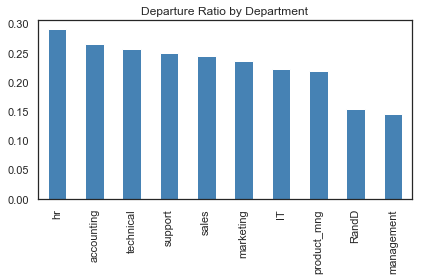

In [14]:
# Turnover Rate by Department
hr.groupby('department')['left'].mean().sort_values(ascending=False).plot(kind='bar', color='steelblue')
plt.title('Departure Ratio by Department')
plt.xlabel('')
plt.tight_layout()

Some observations can be inferred:
- Departure rate differs depending on the department, but **no clear outlier is detected**.
- HR has the **highest turnover rate**.
- R&D and Management have a **significantly lower turnover rate**.

#### Turnover by Satisfaction Level

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


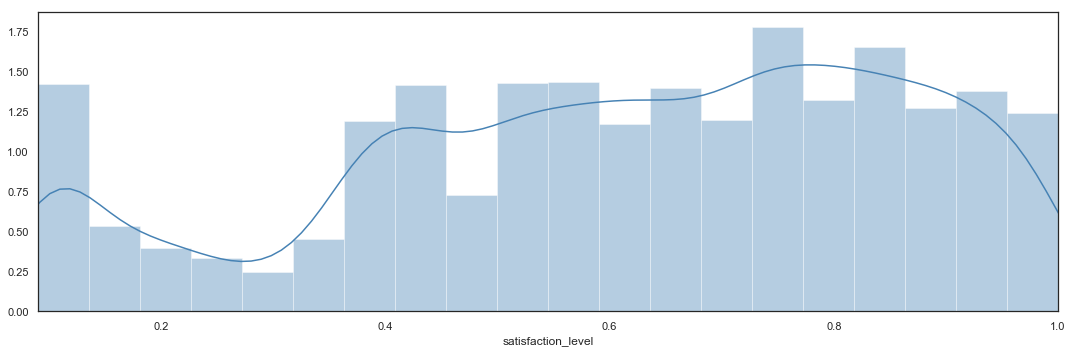

In [15]:
# Bar Plot
plt.figure(figsize=(15,5))
sns.distplot(hr.satisfaction_level,
             bins = 20,
             color = 'steelblue').axes.set_xlim(min(hr.satisfaction_level),max(hr.satisfaction_level))
plt.tight_layout()

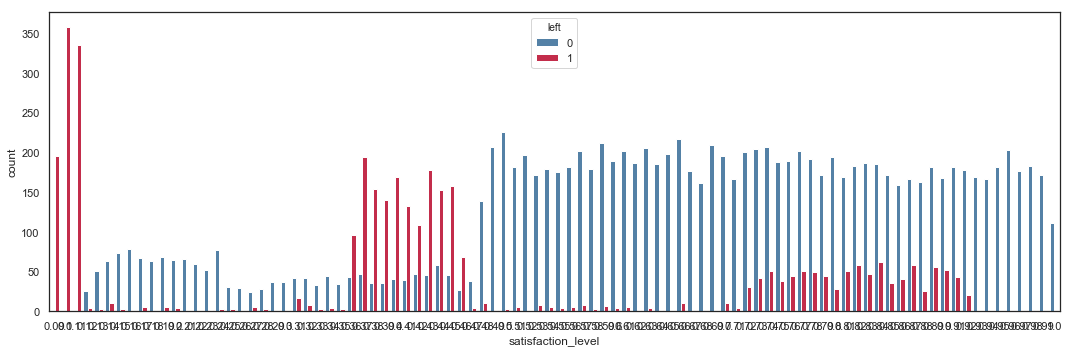

In [16]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.countplot(hr['satisfaction_level'],
              hue = hr['left'],
              palette = ('steelblue', 'crimson'))
plt.tight_layout()

The Satisfaction Level shows 3 interesting areas:
- Employees leave the company *below 0.12*.
- There is a **high rate of departure between 0.36 and 0.46**.
- Turnover rate is **higher between 0.72 and 0.92**.

Employees with very low satisfaction level obviously leave the company. The risky zone is when employees rates their satisfaction just below 0.5. Employees also tend to leave the company when they become moderately satisfied.

#### Turnover by Last Evaluation

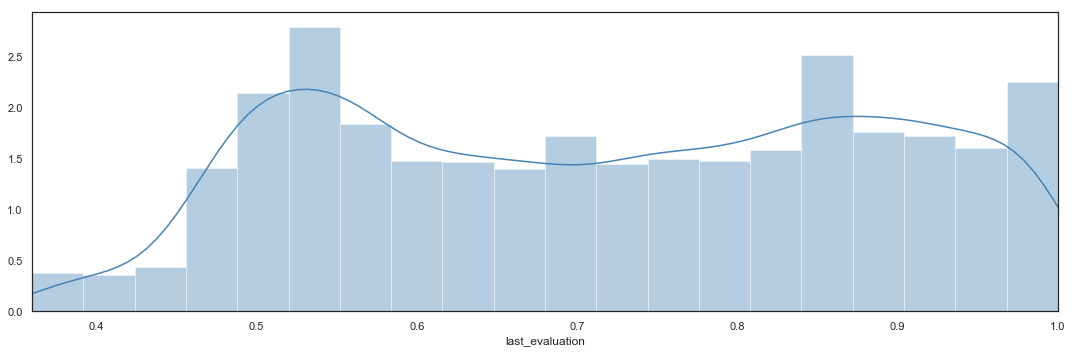

In [17]:
# Bar Plot
plt.figure(figsize=(15,5))
sns.distplot(hr.last_evaluation,
             bins = 20,
             color = 'steelblue').axes.set_xlim(min(hr.last_evaluation),max(hr.last_evaluation))
plt.tight_layout()

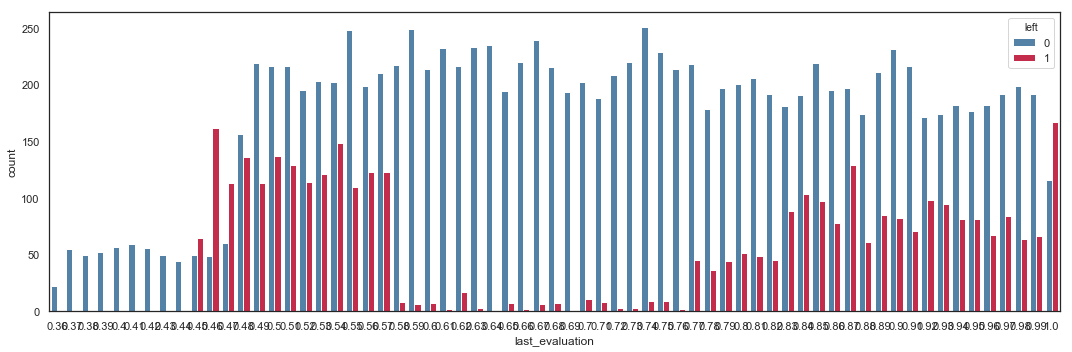

In [18]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.countplot(hr['last_evaluation'],
              hue = hr['left'],
              palette = ('steelblue', 'crimson'))
plt.tight_layout()

The Last Evaluation shows 2 interesting areas:
- Turnover rate is **higher between 0.45 and 0.57**.
- Turnover rate is **higher above 0.77**.

Employees with low evaluation scores tend to leave the company. A large number of good employees leave the company, maybe to get a better opportunity. Interestingly, the ones with very low scores seem to stay.

#### Turnover by Number of Projects

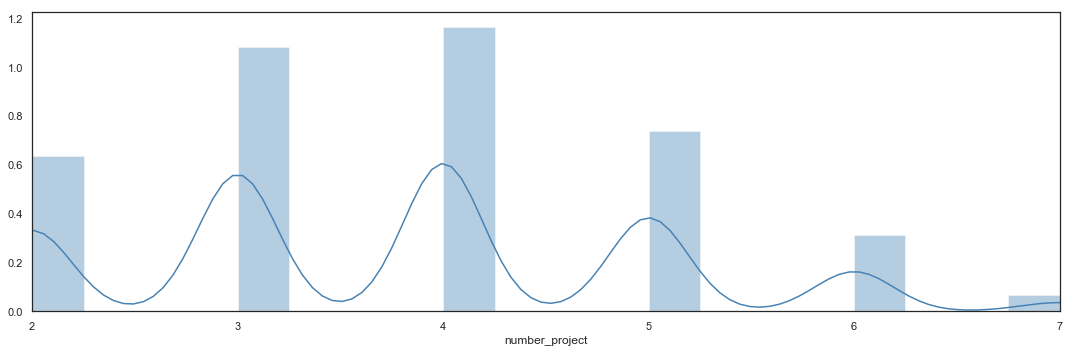

In [19]:
# Bar Plot
plt.figure(figsize=(15,5))
sns.distplot(hr.number_project,
             bins = 20,
             color = 'steelblue').axes.set_xlim(min(hr.number_project),max(hr.number_project))
plt.tight_layout()

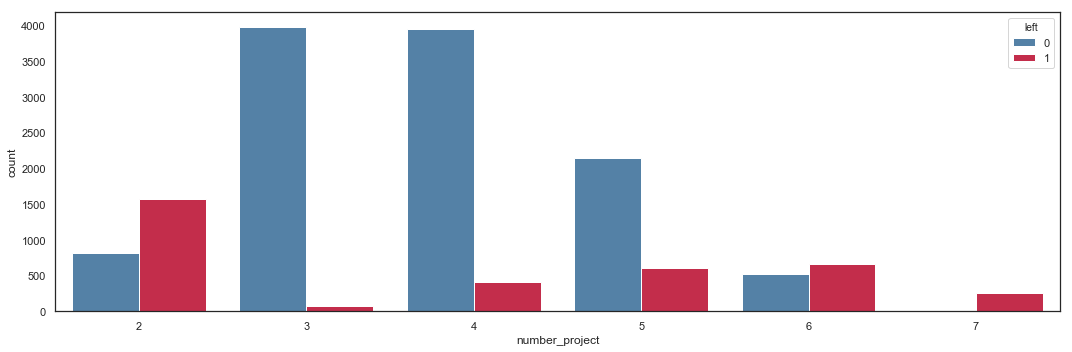

In [20]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.countplot(hr['number_project'],
              hue = hr['left'],
              palette = ('steelblue', 'crimson'))
plt.tight_layout()

The main observation regarding the number of projects is that employees with **only 2 or more than 5 projects** have a higher probability to leave the company.

#### Turnover by Average Monthly Hours

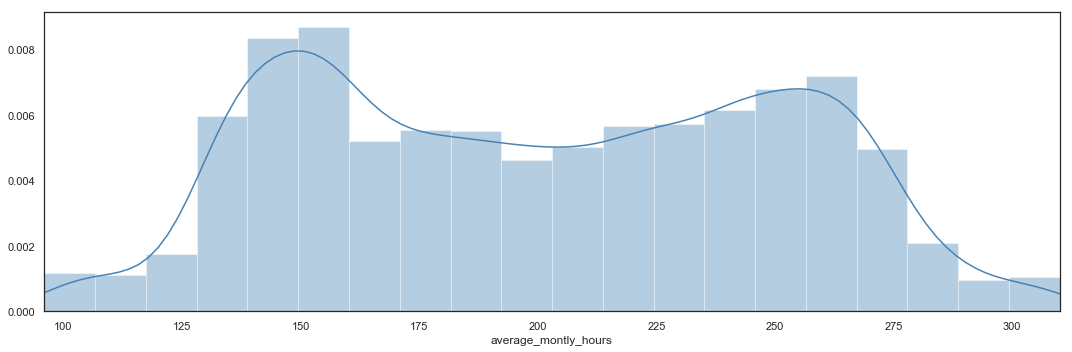

In [21]:
# Bar Plot
plt.figure(figsize=(15,5))
sns.distplot(hr.average_montly_hours,
             bins = 20,
             color = 'steelblue').axes.set_xlim(min(hr.average_montly_hours),max(hr.average_montly_hours))
plt.tight_layout()

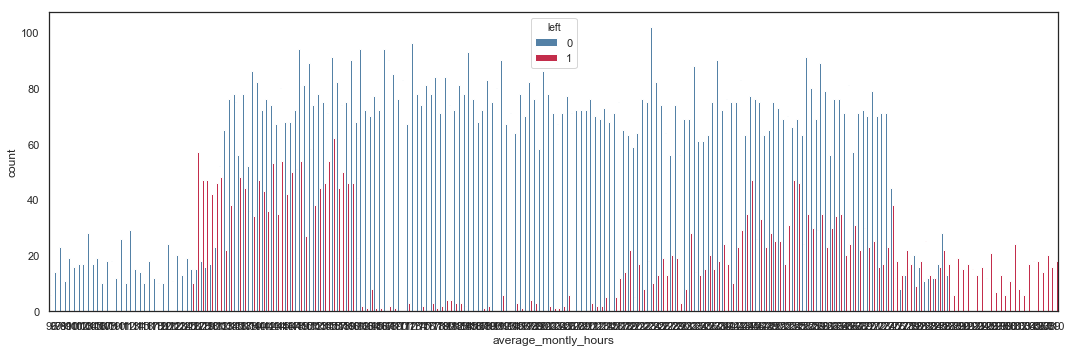

In [22]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.countplot(hr['average_montly_hours'],
              hue = hr['left'],
              palette = ('steelblue', 'crimson'))
plt.tight_layout()

The Average Monthly Hours shows 5 interesting areas:
- Turnover rate is **0% below 125 hours**.
- Turnover rate is **high between 126 and 161 hours**.
- Turnover rate is **moderate between 217 and 274 hours**.
- Turnover rate is **roughly around 50% between 275 and 287 hours**.
- Turnover rate is **100% above 288 hours**.

Employees with really low numbers of hours per month (below 125) tend to stay in the company, whereas employees working too many hours (above 275 hours) have a high probability to leave the company. **A 'safe' range is between 161 and 217 hours**, which seems to be ideal to keep employees in the company.

#### Turnover by Time Spent in the Company

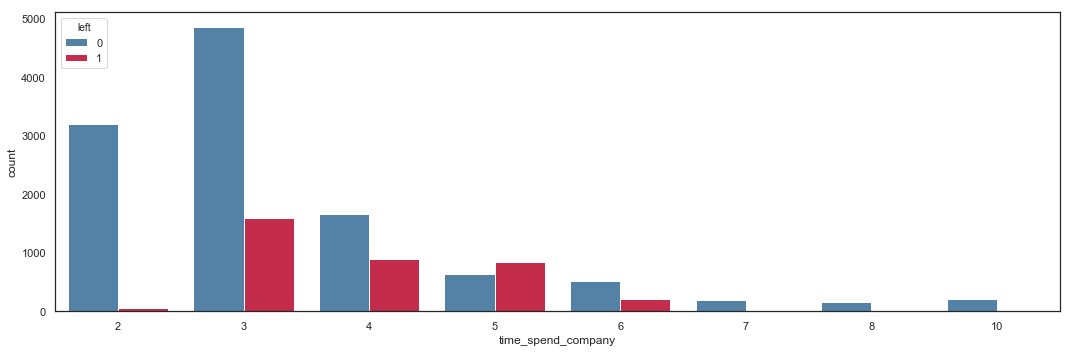

In [23]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.countplot(hr['time_spend_company'],
              hue = hr['left'],
              palette = ('steelblue', 'crimson'))
plt.tight_layout()

It seems that employees with **3-6 years of services** are leaving the company.

#### Turnover by Work Accident

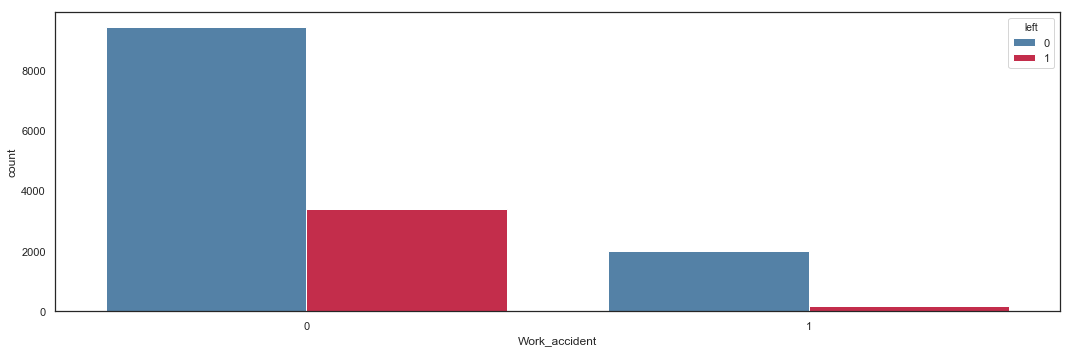

In [24]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.countplot(hr['Work_accident'],
              hue = hr['left'],
              palette = ('steelblue', 'crimson'))
plt.tight_layout()

Employees with a work accident tend to stay in the company.

#### Turnover by Promotion within the past 5 years

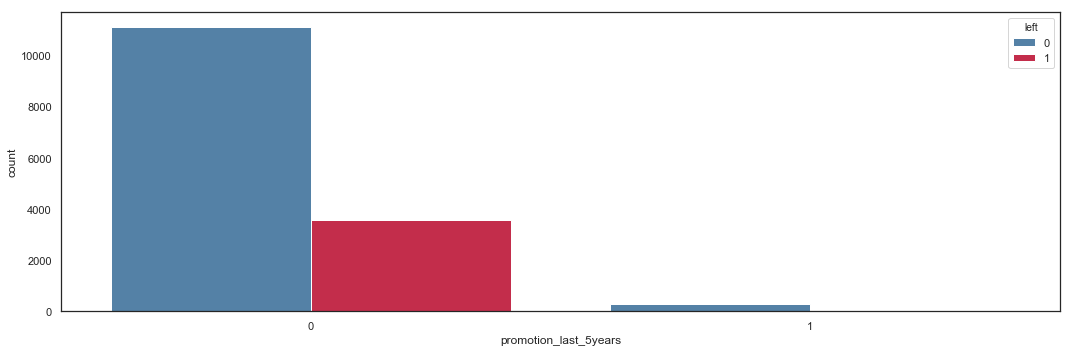

In [25]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.countplot(hr['promotion_last_5years'],
              hue = hr['left'],
              palette = ('steelblue', 'crimson'))
plt.tight_layout()

In [26]:
print('Turnover Rate if Promotion:', round(len(hr[(hr['promotion_last_5years']==1)&(hr['left']==1)])/len(hr[(hr['promotion_last_5years']==1)])*100,2),'%')
print('Turnover Rate if No Promotion:', round(len(hr[(hr['promotion_last_5years']==0)&(hr['left']==1)])/len(hr[(hr['promotion_last_5years']==0)])*100,2),'%')

Turnover Rate if Promotion: 5.96 %
Turnover Rate if No Promotion: 24.2 %


It appears that employees with a promotion within the past 5 years have less propensity to leave the company.

#### Number of Projects vs Average Monthly Hours

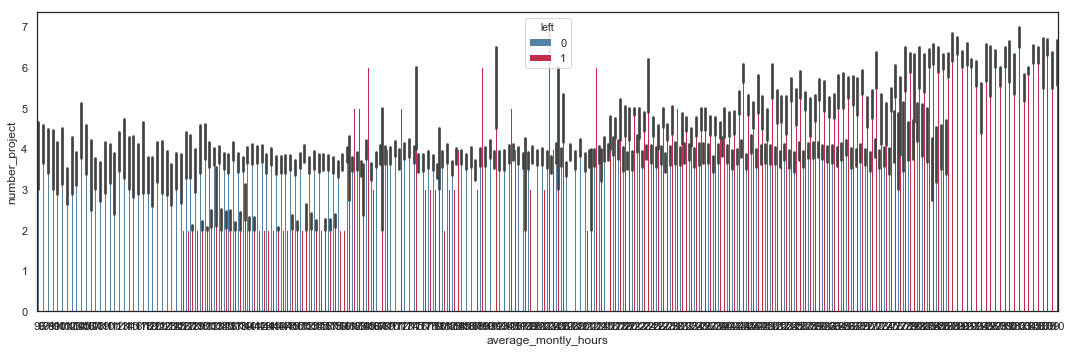

In [27]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.barplot(x=hr.average_montly_hours,
            y=hr.number_project,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

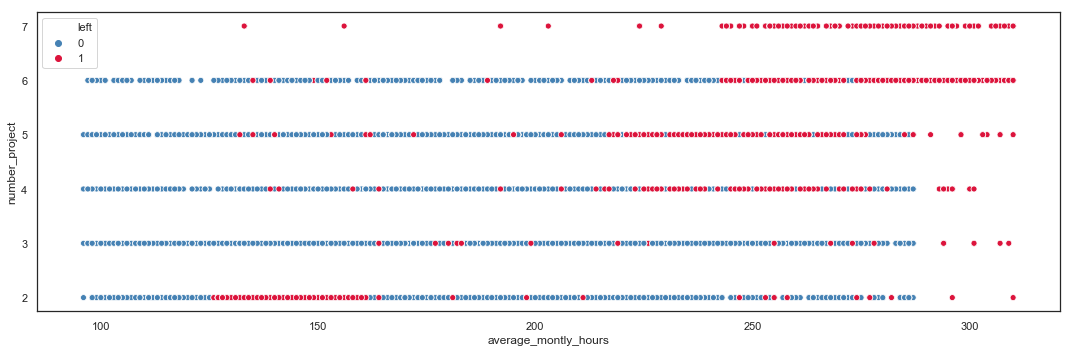

In [28]:
# Scatter Plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr.average_montly_hours,
            y=hr.number_project,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

It appears that:
- employees with **more than 4 projects** and working **more than 217 hours** tend to leave the company.
- employees with **less than 3 projects** and working **less than 161 hours** tend to leave the company.

A high or a low workload seem to push employees out.

#### Number of Projects vs Last Evaluation

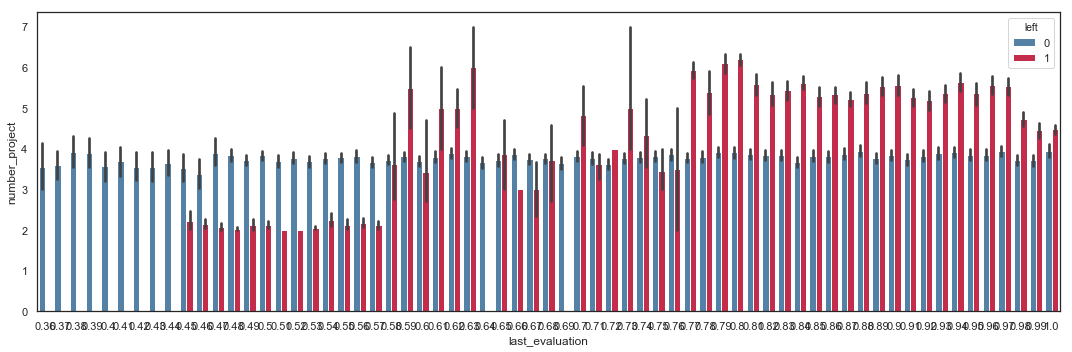

In [29]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.barplot(x=hr.last_evaluation,
            y=hr.number_project,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

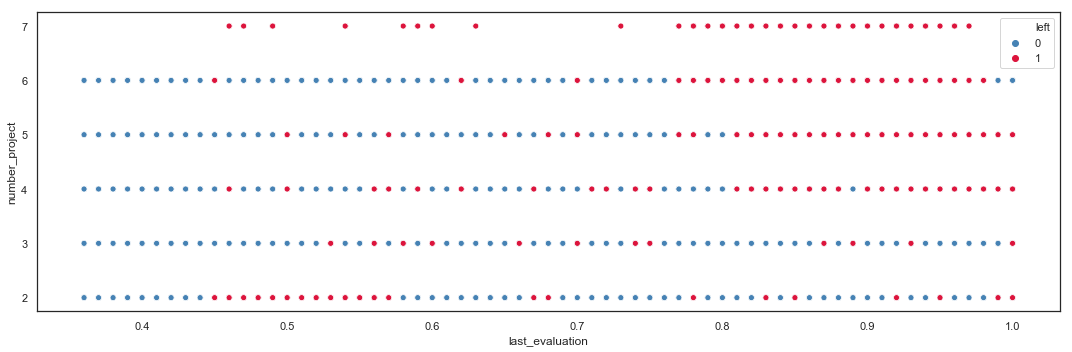

In [30]:
# Scatter Plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr.last_evaluation,
            y=hr.number_project,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

Employees with **more than 4 projects** seem to have **higher evaluations** but leave the company. Employees with **2 projects and a low evaluation** leave the company. 

#### Last Evaluation vs Average Monthly Hours

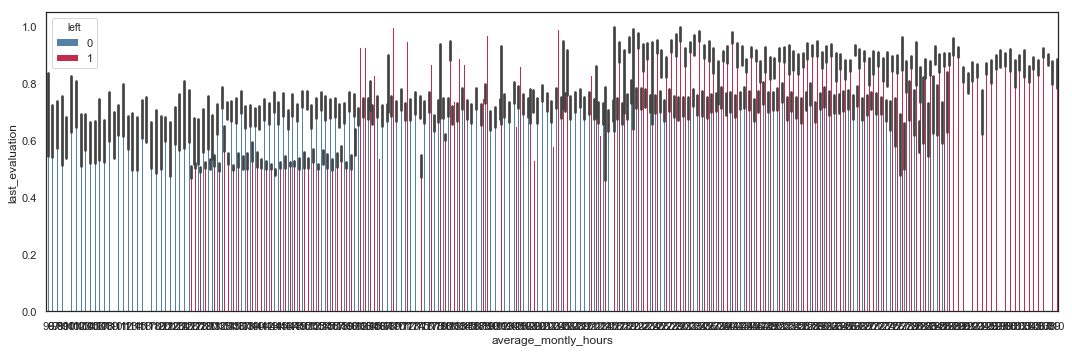

In [31]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.barplot(x=hr.average_montly_hours,
            y=hr.last_evaluation,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

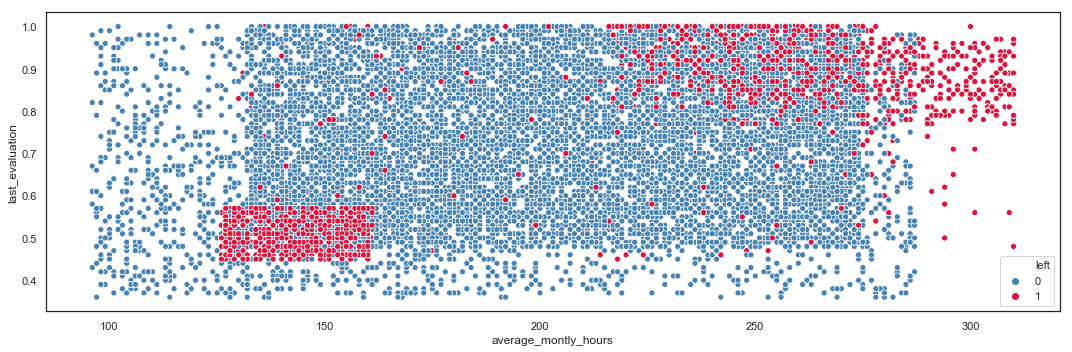

In [32]:
# Scatter Plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr.average_montly_hours,
            y=hr.last_evaluation,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

Employees with **high evaluation** and working **more than 217 hours** tend to leave the company. Employees with **evaluation around 0.5** and working **between 125 and 161 hours** tend to leave the company.

#### Last Evaluation vs Satisfaction Level

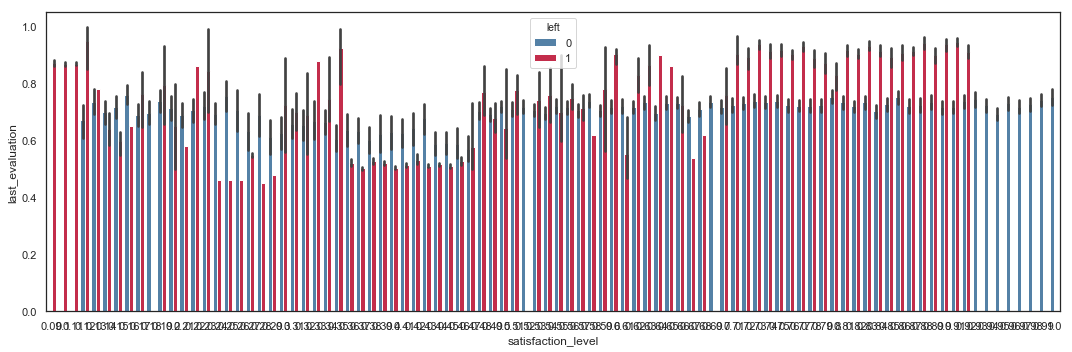

In [33]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.barplot(x=hr.satisfaction_level,
            y=hr.last_evaluation,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

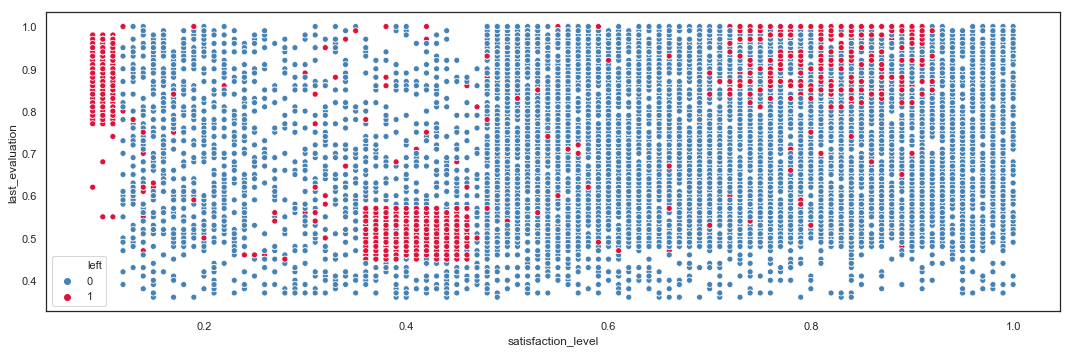

In [34]:
# Scatter Plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr.satisfaction_level,
            y=hr.last_evaluation,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

Employees with **satisfaction level below 0.11** tend to leave the company. Employees with **satisfaction level between 0.35 and 0.46** and with **last evaluation between 0.44 and 0.57** tend to leave the company. Employees with **satisfaction level between 0.71 and 0.92** and with **last evaluation between 0.76 and 1** tend to leave the company.

### Encoding Categorical Variables

The variable `salary` will be encoded using ordinal encoding and `department` will be encoded using one-hot encoding.

In [35]:
# Encoding the variable salary
salary_dict = {'low':0,'medium':1,'high':2}
hr['salary_num'] = hr.salary.map(salary_dict)
hr.drop('salary', inplace=True, axis=1)
hr = hr.rename(index=str, columns={'salary_num':'salary'})
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,0
1,0.80,0.86,5,262,6,0,1,0,sales,1
2,0.11,0.88,7,272,4,0,1,0,sales,1
3,0.72,0.87,5,223,5,0,1,0,sales,0
4,0.37,0.52,2,159,3,0,1,0,sales,0


In [36]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    return(list(set(df.columns) - set(numerical_columns)))

def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

In [37]:
hr_encoded = onehot_encode(hr)
hr_encoded.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [38]:
df_desc(hr_encoded)

,dtype,NAs,Numerical,Boolean,Categorical
satisfaction_level,float64,0,True,False,False
last_evaluation,float64,0,True,False,False
number_project,int64,0,True,False,False
average_montly_hours,int64,0,True,False,False
time_spend_company,int64,0,True,False,False
Work_accident,int64,0,False,True,False
left,int64,0,False,True,False
promotion_last_5years,int64,0,False,True,False
salary,int64,0,True,False,False
department_IT,uint8,0,False,True,False


### Scaling and Skewness

Numerical variables `average_monthly_hours`, `last_evaluation` and `satisfaction_level` are scaled to remove any influence of their difference in value ranges on the model.

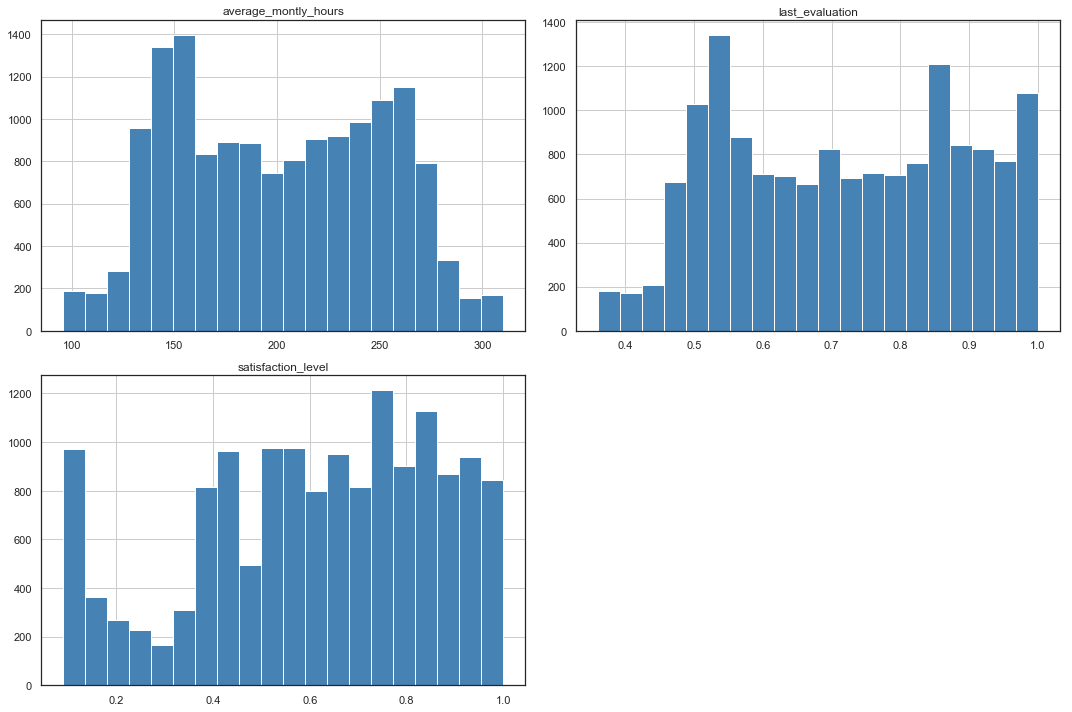

In [39]:
hr_encoded[['satisfaction_level',
           'last_evaluation',
           'average_montly_hours'
           ]].hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

In [40]:
hr_encoded[['satisfaction_level',
           'last_evaluation',
           'average_montly_hours'
           ]].describe()

,satisfaction_level,last_evaluation,average_montly_hours
count,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,201.050337
std,0.248631,0.171169,49.943099
min,0.090000,0.360000,96.000000
25%,0.440000,0.560000,156.000000
50%,0.640000,0.720000,200.000000
75%,0.820000,0.870000,245.000000
max,1.000000,1.000000,310.000000


In [41]:
scaler = preprocessing.MinMaxScaler()
hr_scaled_part = scaler.fit_transform(hr_encoded[['satisfaction_level',
                                                  'last_evaluation',
                                                  'average_montly_hours']])
hr_scaled_part = pd.DataFrame(hr_scaled_part, columns=list(['satisfaction_level',
                                                  'last_evaluation',
                                                  'average_montly_hours']))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


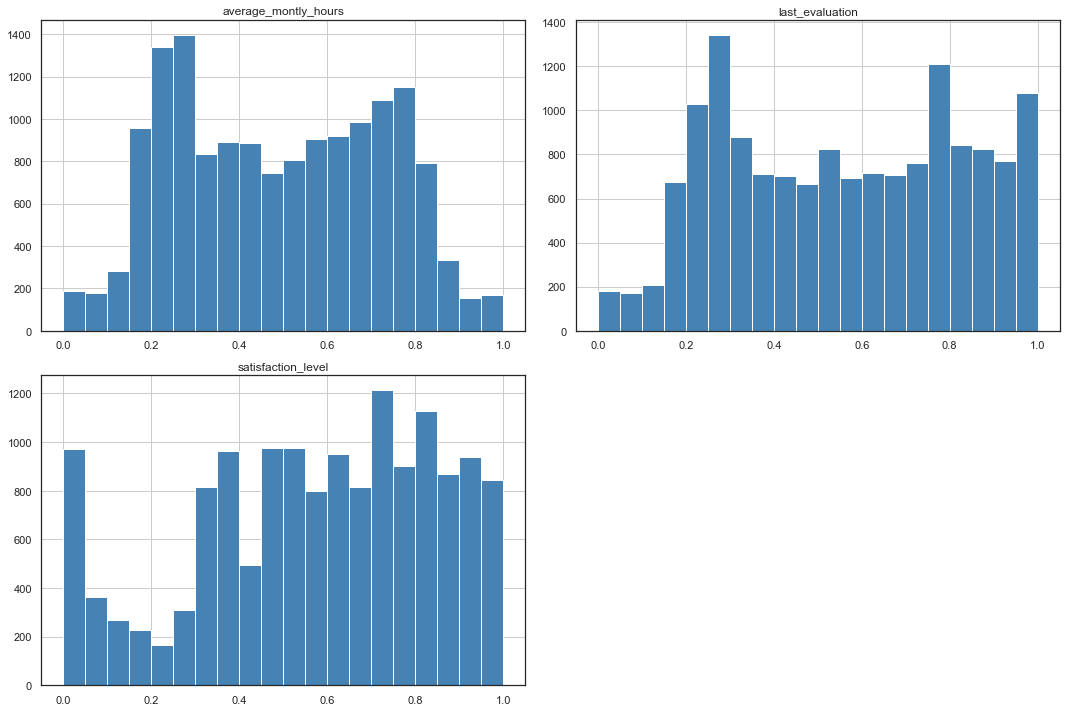

In [42]:
hr_scaled_part[['satisfaction_level',
                'last_evaluation',
                'average_montly_hours']].hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

In [43]:
hr_scaled_part.describe()

,satisfaction_level,last_evaluation,average_montly_hours
count,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.490889
std,0.273220,0.267452,0.233379
min,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.280374
50%,0.604396,0.562500,0.485981
75%,0.802198,0.796875,0.696262
max,1.000000,1.000000,1.000000


The skewness of the scaled variables is then fixed.

In [44]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

In [45]:
def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

In [46]:
hr_skewed_part = fix_skewness(hr_scaled_part)

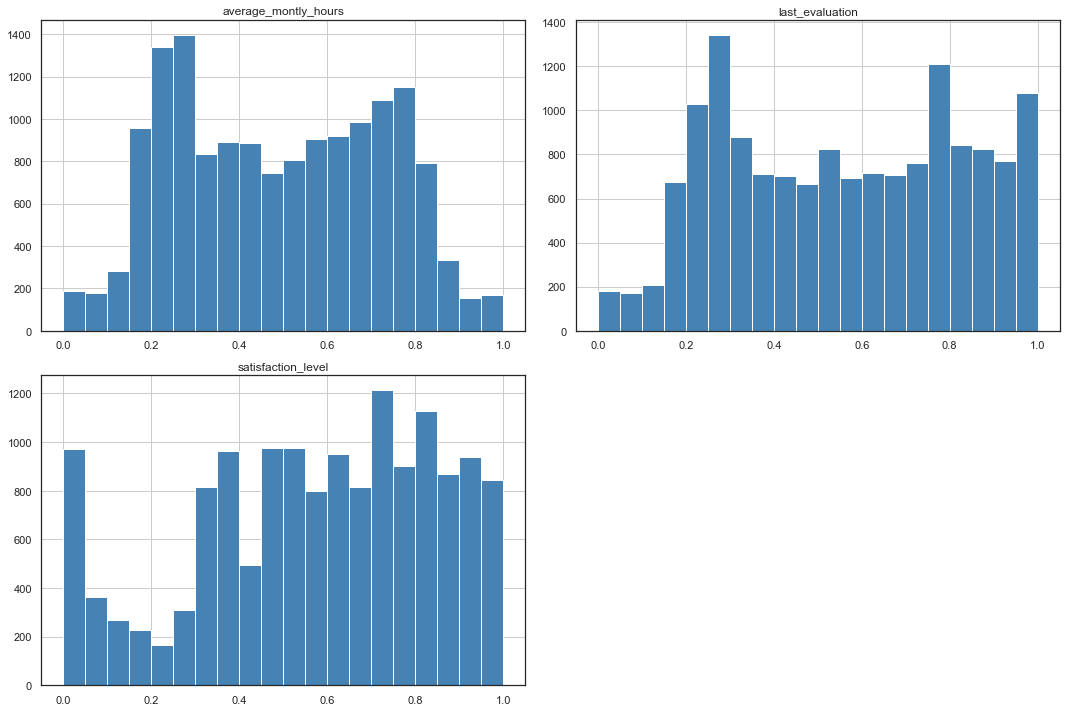

In [47]:
hr_skewed_part.hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

In [48]:
hr_skewed_part.describe()

,satisfaction_level,last_evaluation,average_montly_hours
count,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.490889
std,0.273220,0.267452,0.233379
min,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.280374
50%,0.604396,0.562500,0.485981
75%,0.802198,0.796875,0.696262
max,1.000000,1.000000,1.000000


The resulting values aren't different than the initial ones, showing that the data wasn't skewed.

In [49]:
hr_simple = hr_encoded.copy()
hr_simple.drop(['satisfaction_level',
                'last_evaluation',
                'average_montly_hours'], inplace=True, axis=1)

hr_ready = pd.DataFrame()
hr_simple.reset_index(drop=True, inplace=True)
hr_skewed_part.reset_index(drop=True, inplace=True)

hr_ready = pd.concat([hr_skewed_part,hr_simple], axis=1, sort=False, ignore_index=False)

# hr_ready['number_project'] = hr_ready['number_project'].astype('category').cat.codes
# hr_ready['time_spend_company'] = hr_ready['time_spend_company'].astype('category').cat.codes

hr_ready.head()

,satisfaction_level,last_evaluation,average_montly_hours,number_project,time_spend_company,Work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.318681,0.265625,0.285047,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.780220,0.781250,0.775701,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.021978,0.812500,0.822430,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.692308,0.796875,0.593458,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.307692,0.250000,0.294393,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [50]:
df_desc(hr_ready)

,dtype,NAs,Numerical,Boolean,Categorical
satisfaction_level,float64,0,True,False,False
last_evaluation,float64,0,True,False,False
average_montly_hours,float64,0,True,False,False
number_project,int64,0,True,False,False
time_spend_company,int64,0,True,False,False
Work_accident,int64,0,False,True,False
left,int64,0,False,True,False
promotion_last_5years,int64,0,False,True,False
salary,int64,0,True,False,False
department_IT,uint8,0,False,True,False


In [51]:
hr_ready.describe()

,satisfaction_level,last_evaluation,average_montly_hours,number_project,time_spend_company,Work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.490889,3.803054,3.498233,0.144610,0.238083,0.021268,0.594706,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345
std,0.273220,0.267452,0.233379,1.232592,1.460136,0.351719,0.425924,0.144281,0.637183,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317
min,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.280374,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,0.485981,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.802198,0.796875,0.696262,5.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,7.000000,10.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


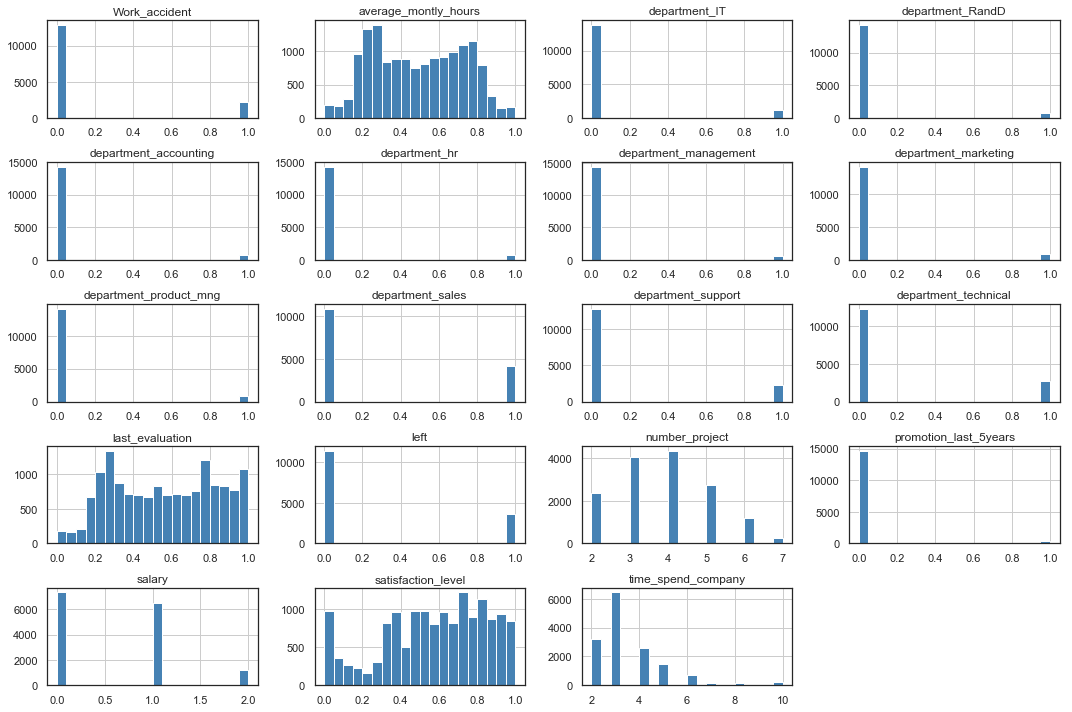

In [52]:
hr_ready.hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

The dataset is now ready to go through the baseline and feature engineering phases.

### Training/Test Split

The model target `left` is defined, taking all other variables as features. The dataset is split in a train set and a test set, using a random split with ratio 70|30.

In [53]:
target = 'left'

split_ratio = 0.3
seed = 806

def split_dataset(df, target, split_ratio=0.3, seed=806):
    features = list(df)
    features.remove(target)

    X = df[features]
    y = df[[target]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=seed)

    return X, y, X_train, X_test, y_train, y_test

X, y, X_train, X_test, y_train, y_test = split_dataset(hr_ready, target, split_ratio, seed)

print('Features:',X.shape[0], 'items | ', X.shape[1],'columns')
print('Target:',y.shape[0], 'items | ', y.shape[1],'columns')
print('Features Train:',X_train.shape[0], 'items | ', X_train.shape[1],'columns')
print('Features Test:',X_test.shape[0], 'items | ', X_test.shape[1],'columns')
print('Target Train:',y_train.shape[0], 'items | ', y_train.shape[1],'columns')
print('Target Test:',y_test.shape[0], 'items | ', y_test.shape[1],'columns')

Features: 14999 items |  18 columns
Target: 14999 items |  1 columns
Features Train: 10499 items |  18 columns
Features Test: 4500 items |  18 columns
Target Train: 10499 items |  1 columns
Target Test: 4500 items |  1 columns


---

## Baseline

A logistic regression algorithm will be used to develop this classification model.

In [54]:
lr = LogisticRegression(solver='lbfgs', max_iter = 300)

In [55]:
def lr_run(model, X_train, y_train, X_test, y_test):
    result = model.fit(X_train, y_train.values.ravel())

    y_pred = model.predict(X_test)
    acc_test = model.score(X_test, y_test)
    coefficients = pd.concat([pd.DataFrame(X_train.columns, columns=['Feature']), pd.DataFrame(np.transpose(model.coef_), columns=['Coef.'])], axis = 1)
    coefficients.loc[-1] = ['intercept.', model.intercept_[0]]
    coefficients.index = coefficients.index + 1
    coefficients = coefficients.sort_index()
    
    print('Accuracy on test: {:.3f}'.format(acc_test))
    print()
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print(coefficients)

In [56]:
lr_run(lr, X_train, y_train, X_test, y_test)

Accuracy on test: 0.797

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      3435
           1       0.63      0.34      0.44      1065

   micro avg       0.80      0.80      0.80      4500
   macro avg       0.73      0.64      0.66      4500
weighted avg       0.78      0.80      0.77      4500

Confusion Matrix:
[[3220  215]
 [ 700  365]]

                   Feature     Coef.
0               intercept.  0.652320
1       satisfaction_level -3.616897
2          last_evaluation  0.440219
3     average_montly_hours  0.910047
4           number_project -0.285360
5       time_spend_company  0.245415
6            Work_accident -1.394756
7    promotion_last_5years -1.189347
8                   salary -0.695794
9            department_IT -0.065202
10        department_RandD -0.474089
11   department_accounting  0.069995
12           department_hr  0.336695
13   department_management -0.352861
14    department_marketing  0.062124
15  depart

The ROC Curve can be plot for the model.

In [57]:
def plot_roc(model, X_test, y_test):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show();

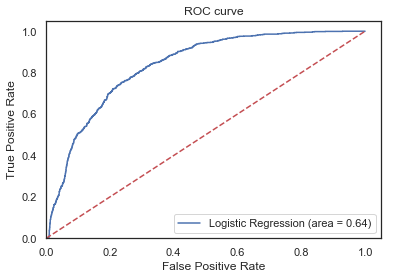

In [58]:
plot_roc(lr, X_test, y_test)

---

## Feature Engineering

### Cross Validation Strategy

The model is cross-validated using a 10-fold cross validation and returning the average accuracy.  
Example based on the baseline:

In [59]:
def cv_acc (model, X_train, y_train, n_splits, seed):
    kfold = model_selection.KFold(n_splits=n_splits, random_state=seed)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    print("10-fold cross validation average accuracy: %.3f" % (results.mean()))
    print()
    for i in range(len(results)):
        print('Iteration', '{:>2}'.format(i+1), '| Accuracy: {:.2f}'.format(results[i]))

In [60]:
cv_acc(lr, X_train, y_train, 10, seed)

10-fold cross validation average accuracy: 0.789

Iteration  1 | Accuracy: 0.79
Iteration  2 | Accuracy: 0.77
Iteration  3 | Accuracy: 0.78
Iteration  4 | Accuracy: 0.80
Iteration  5 | Accuracy: 0.81
Iteration  6 | Accuracy: 0.79
Iteration  7 | Accuracy: 0.79
Iteration  8 | Accuracy: 0.80
Iteration  9 | Accuracy: 0.79
Iteration 10 | Accuracy: 0.77


### Features Construction

The dataset is copied to add or modify features.

In [61]:
hr_fe = hr_ready.copy()

#### Bin Satisfaction Level

Based on the EDA, we can bin the Satisfaction Level into 6 bins.

In [62]:
bins = [-1, 0.03, 0.29, 0.41, 0.69, 0.92, 1]
labels=['(0.00, 0.11]','(0.11, 0.35]','(0.35, 0.46]','(0.46, 0.71]','(0.71, 0.92]','(0.92, 1.00]']
hr_fe['satisfaction_level_bin'] = pd.cut(hr_fe.satisfaction_level, bins, labels=labels)
hr_fe.satisfaction_level_bin.value_counts()

(0.71, 0.92]    4765
(0.46, 0.71]    4689
(0.35, 0.46]    2012
(0.92, 1.00]    1362
(0.11, 0.35]    1283
(0.00, 0.11]     888
Name: satisfaction_level_bin, dtype: int64

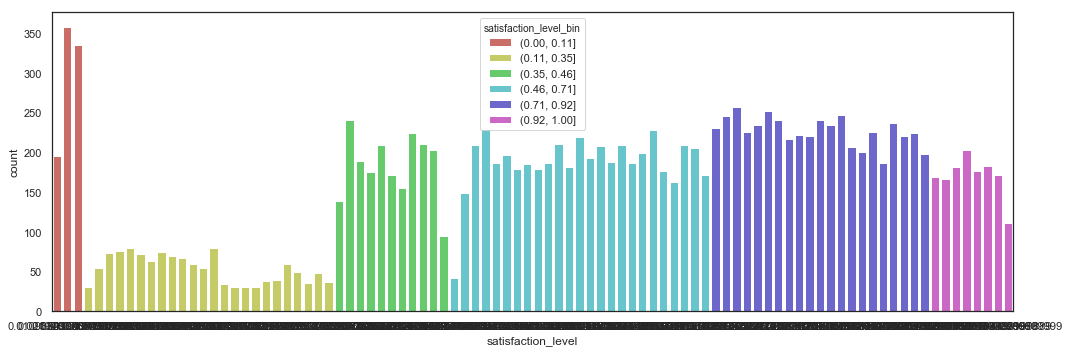

In [63]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe.satisfaction_level,
              hue=hr_fe.satisfaction_level_bin,
              palette = sns.color_palette("hls", 6),
              dodge = False)
plt.tight_layout()

In [64]:
hr_fe_1 = hr_fe.copy()
hr_fe_1 = onehot_encode(hr_fe_1)
hr_fe_1.drop('satisfaction_level', inplace=True, axis=1)

In [65]:
X_fe_1, y_fe_1, X_fe_1_train, X_fe_1_test, y_fe_1_train, y_fe_1_test = split_dataset(hr_fe_1, target, split_ratio, seed)
cv_acc(lr, X_fe_1_train, y_fe_1_train, 10, seed)
print()
lr_run(lr, X_fe_1_train, y_fe_1_train, X_fe_1_test, y_fe_1_test)

10-fold cross validation average accuracy: 0.916

Iteration  1 | Accuracy: 0.92
Iteration  2 | Accuracy: 0.92
Iteration  3 | Accuracy: 0.90
Iteration  4 | Accuracy: 0.91
Iteration  5 | Accuracy: 0.93
Iteration  6 | Accuracy: 0.92
Iteration  7 | Accuracy: 0.92
Iteration  8 | Accuracy: 0.92
Iteration  9 | Accuracy: 0.91
Iteration 10 | Accuracy: 0.91

Accuracy on test: 0.914

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3435
           1       0.83      0.79      0.81      1065

   micro avg       0.91      0.91      0.91      4500
   macro avg       0.89      0.87      0.88      4500
weighted avg       0.91      0.91      0.91      4500

Confusion Matrix:
[[3266  169]
 [ 220  845]]

                                Feature     Coef.
0                            intercept. -4.095534
1                       last_evaluation  1.885761
2                  average_montly_hours  1.871660
3                        number_project -0.118954
4

#### Bin Last Evaluation

Based on the EDA, we can bin the Last Evaluation into 4 bins.

In [66]:
bins = [-1, 0.14, 0.34, 0.64, 1]
labels=['(0.00, 0.44]','(0.44, 0.57]','(0.57, 0.76]','(0.76, 1.00]']
hr_fe['last_evaluation_bin'] = pd.cut(hr_fe.last_evaluation, bins, labels=labels)
hr_fe_1['last_evaluation_bin'] = pd.cut(hr_fe_1.last_evaluation, bins, labels=labels)
hr_fe_1.last_evaluation_bin.value_counts()

(0.76, 1.00]    6458
(0.57, 0.76]    4279
(0.44, 0.57]    3817
(0.00, 0.44]     445
Name: last_evaluation_bin, dtype: int64

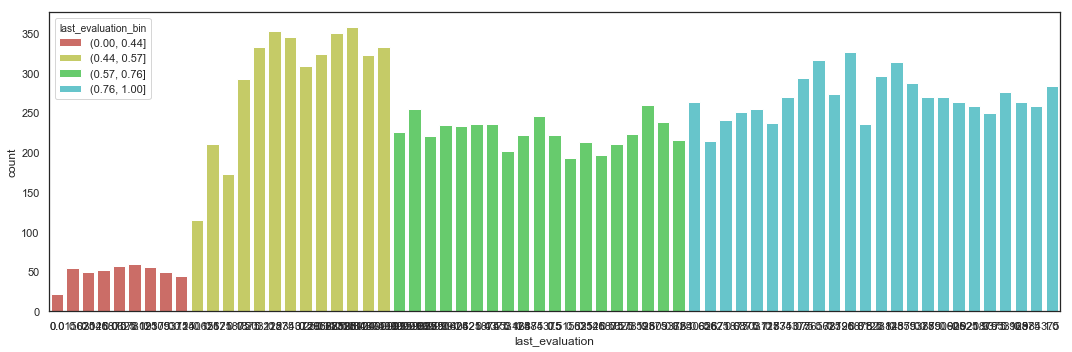

In [67]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_1.last_evaluation,
              hue=hr_fe_1.last_evaluation_bin,
              palette = sns.color_palette("hls", 6),
              dodge = False)
plt.tight_layout()

In [68]:
hr_fe_2 = hr_fe_1.copy()
hr_fe_2 = onehot_encode(hr_fe_2)
hr_fe_2.drop('last_evaluation', inplace=True, axis=1)

In [69]:
X_fe_2, y_fe_2, X_fe_2_train, X_fe_2_test, y_fe_2_train, y_fe_2_test = split_dataset(hr_fe_2, target, split_ratio, seed)
cv_acc(lr, X_fe_2_train, y_fe_2_train, 10, seed)
print()
lr_run(lr, X_fe_2_train, y_fe_2_train, X_fe_2_test, y_fe_2_test)

10-fold cross validation average accuracy: 0.935

Iteration  1 | Accuracy: 0.93
Iteration  2 | Accuracy: 0.93
Iteration  3 | Accuracy: 0.93
Iteration  4 | Accuracy: 0.93
Iteration  5 | Accuracy: 0.94
Iteration  6 | Accuracy: 0.93
Iteration  7 | Accuracy: 0.95
Iteration  8 | Accuracy: 0.94
Iteration  9 | Accuracy: 0.93
Iteration 10 | Accuracy: 0.93

Accuracy on test: 0.936

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3435
           1       0.88      0.84      0.86      1065

   micro avg       0.94      0.94      0.94      4500
   macro avg       0.92      0.90      0.91      4500
weighted avg       0.94      0.94      0.94      4500

Confusion Matrix:
[[3315  120]
 [ 167  898]]

                                Feature     Coef.
0                            intercept. -5.603085
1                  average_montly_hours  2.193703
2                        number_project  0.058753
3                    time_spend_company  0.462998
4

#### Bin Average Monthly Hours

Based on the EDA, we can bin the Average Monthly Hours into 7 bins.

In [70]:
bins = [-1, 0.14, 0.165, 0.304, 0.565, 0.840, 0.897, 1]
labels=['(0, 125]','(125, 131]','(131, 161]','(161, 216]','(216, 274]','(274, 287]','(287, 310]']
hr_fe['average_montly_hours_bin'] = pd.cut(hr_fe.average_montly_hours, bins, labels=labels)
hr_fe_2['average_montly_hours_bin'] = pd.cut(hr_fe_2.average_montly_hours, bins, labels=labels)
hr_fe_2.average_montly_hours_bin.value_counts()

(216, 274]    5573
(161, 216]    4290
(131, 161]    3588
(0, 125]       486
(274, 287]     379
(125, 131]     353
(287, 310]     330
Name: average_montly_hours_bin, dtype: int64

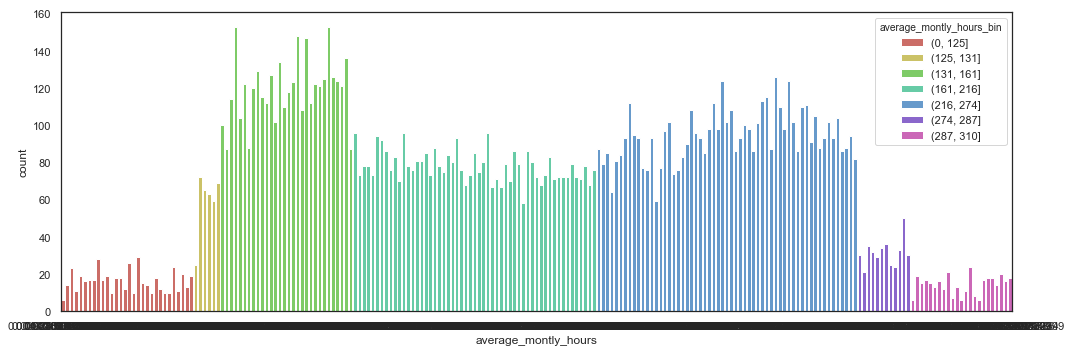

In [71]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_2.average_montly_hours,
              hue=hr_fe_2.average_montly_hours_bin,
              palette = sns.color_palette("hls", 7),
              dodge = False)
plt.tight_layout()

In [72]:
hr_fe_3 = hr_fe_2.copy()
hr_fe_3 = onehot_encode(hr_fe_3)
hr_fe_3.drop('average_montly_hours', inplace=True, axis=1)

In [73]:
X_fe_3, y_fe_3, X_fe_3_train, X_fe_3_test, y_fe_3_train, y_fe_3_test = split_dataset(hr_fe_3, target, split_ratio, seed)
cv_acc(lr, X_fe_3_train, y_fe_3_train, 10, seed)
print()
lr_run(lr, X_fe_3_train, y_fe_3_train, X_fe_3_test, y_fe_3_test)

10-fold cross validation average accuracy: 0.944

Iteration  1 | Accuracy: 0.95
Iteration  2 | Accuracy: 0.94
Iteration  3 | Accuracy: 0.94
Iteration  4 | Accuracy: 0.94
Iteration  5 | Accuracy: 0.95
Iteration  6 | Accuracy: 0.94
Iteration  7 | Accuracy: 0.95
Iteration  8 | Accuracy: 0.95
Iteration  9 | Accuracy: 0.94
Iteration 10 | Accuracy: 0.93

Accuracy on test: 0.945

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3435
           1       0.91      0.86      0.88      1065

   micro avg       0.95      0.95      0.95      4500
   macro avg       0.93      0.92      0.92      4500
weighted avg       0.94      0.95      0.94      4500

Confusion Matrix:
[[3340   95]
 [ 151  914]]

                                Feature     Coef.
0                            intercept. -4.893750
1                        number_project  0.162189
2                    time_spend_company  0.452624
3                         Work_accident -1.155125
4

#### Categorize Number of Projects

Based on the EDA, the Number of Projects can be categorized into 4 categories.

In [74]:
categ = {2:'too low', 3:'normal', 4:'normal', 5:'normal', 6:'too high', 7:'extreme'}
hr_fe['number_project_cat'] = hr_fe.number_project.map(categ)
hr_fe_3['number_project_cat'] = hr_fe_3.number_project.map(categ)
hr_fe_3.number_project_cat.value_counts()

normal      11181
too low      2388
too high     1174
extreme       256
Name: number_project_cat, dtype: int64

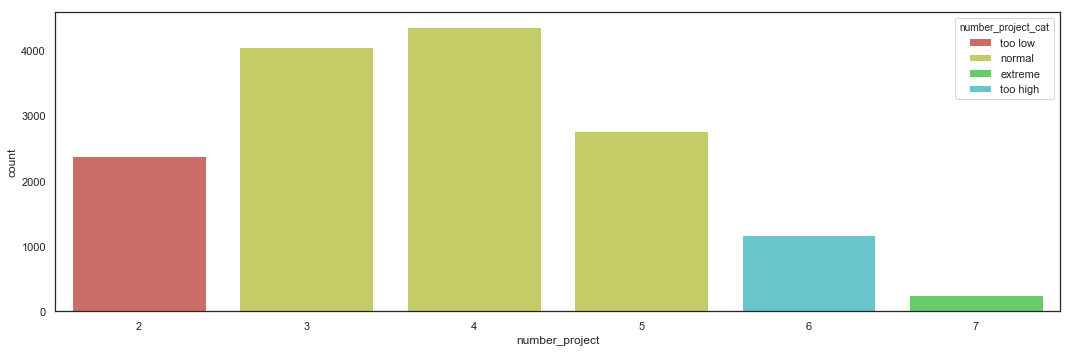

In [75]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_3.number_project,
              hue=hr_fe_3.number_project_cat,
              palette = sns.color_palette("hls", 6),
              dodge = False)
plt.tight_layout()

In [76]:
hr_fe_4 = hr_fe_3.copy()
hr_fe_4 = onehot_encode(hr_fe_4)
hr_fe_4.drop('number_project', inplace=True, axis=1)

In [77]:
X_fe_4, y_fe_4, X_fe_4_train, X_fe_4_test, y_fe_4_train, y_fe_4_test = split_dataset(hr_fe_4, target, split_ratio, seed)
cv_acc(lr, X_fe_4_train, y_fe_4_train, 10, seed)
print()
lr_run(lr, X_fe_4_train, y_fe_4_train, X_fe_4_test, y_fe_4_test)

10-fold cross validation average accuracy: 0.946

Iteration  1 | Accuracy: 0.94
Iteration  2 | Accuracy: 0.94
Iteration  3 | Accuracy: 0.94
Iteration  4 | Accuracy: 0.95
Iteration  5 | Accuracy: 0.96
Iteration  6 | Accuracy: 0.94
Iteration  7 | Accuracy: 0.96
Iteration  8 | Accuracy: 0.96
Iteration  9 | Accuracy: 0.94
Iteration 10 | Accuracy: 0.94

Accuracy on test: 0.950

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3435
           1       0.90      0.88      0.89      1065

   micro avg       0.95      0.95      0.95      4500
   macro avg       0.93      0.93      0.93      4500
weighted avg       0.95      0.95      0.95      4500

Confusion Matrix:
[[3333  102]
 [ 125  940]]

                                Feature     Coef.
0                            intercept. -2.841608
1                    time_spend_company  0.507726
2                         Work_accident -1.202049
3                 promotion_last_5years -0.838310
4

#### Categorize Time Spent in Company

Based on the EDA, the Time Spent in Company can be categorized into 4 categories, related to the rate of departure.

In [78]:
categ = {2:'low departure', 3:'high departure', 4:'high departure', 5:'very high departure', 6:'high departure', 7:'no departure', 8:'no departure', 10:'no departure'}
hr_fe['time_spend_company_cat'] = hr_fe.time_spend_company.map(categ)
hr_fe_4['time_spend_company_cat'] = hr_fe_4.time_spend_company.map(categ)
hr_fe_4.time_spend_company_cat.value_counts()

high departure         9718
low departure          3244
very high departure    1473
no departure            564
Name: time_spend_company_cat, dtype: int64

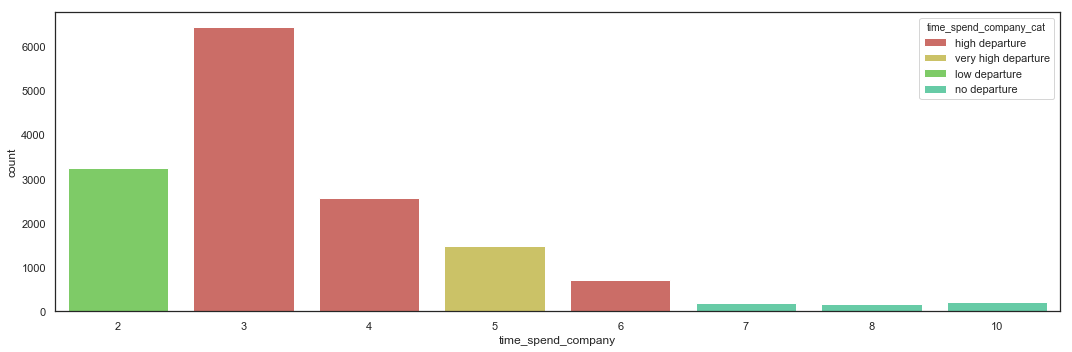

In [79]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_4.time_spend_company,
              hue=hr_fe_4.time_spend_company_cat,
              palette = sns.color_palette("hls", 7),
              dodge = False)
plt.tight_layout()

In [80]:
hr_fe_5 = hr_fe_4.copy()
hr_fe_5 = onehot_encode(hr_fe_5)
hr_fe_5.drop('time_spend_company', inplace=True, axis=1)

In [81]:
X_fe_5, y_fe_5, X_fe_5_train, X_fe_5_test, y_fe_5_train, y_fe_5_test = split_dataset(hr_fe_5, target, split_ratio, seed)
cv_acc(lr, X_fe_5_train, y_fe_5_train, 10, seed)
print()
lr_run(lr, X_fe_5_train, y_fe_5_train, X_fe_5_test, y_fe_5_test)

10-fold cross validation average accuracy: 0.956

Iteration  1 | Accuracy: 0.95
Iteration  2 | Accuracy: 0.94
Iteration  3 | Accuracy: 0.95
Iteration  4 | Accuracy: 0.96
Iteration  5 | Accuracy: 0.96
Iteration  6 | Accuracy: 0.96
Iteration  7 | Accuracy: 0.96
Iteration  8 | Accuracy: 0.96
Iteration  9 | Accuracy: 0.96
Iteration 10 | Accuracy: 0.95

Accuracy on test: 0.956

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3435
           1       0.93      0.88      0.91      1065

   micro avg       0.96      0.96      0.96      4500
   macro avg       0.95      0.93      0.94      4500
weighted avg       0.96      0.96      0.96      4500

Confusion Matrix:
[[3362   73]
 [ 124  941]]

                                       Feature     Coef.
0                                   intercept. -1.288513
1                                Work_accident -1.210856
2                        promotion_last_5years -0.454837
3                      

#### Cluster by Number of Projects and Average Monthly Hours

Based on the EDA, the employees can be clustered by Workload, based on the Number of Projects and Average Monthly Hours, into 5 categories.

In [82]:
def workload_cluster(row):
    if (row['average_montly_hours_bin'] == '(0, 125]'):
        return 'very low'
    if (row['number_project'] <= 2) and (row['average_montly_hours_bin'] in ['(125, 131]','(131, 161]']):
        return 'low'
    if (row['number_project'] >= 4) and (row['average_montly_hours_bin'] in ['(216, 274]','(274, 287]']):
        return 'high'
    if (row['average_montly_hours_bin'] in ['(287, 310]']):
        return 'extreme'
    return 'normal'

hr_fe['workload'] = hr_fe.apply(lambda row: workload_cluster(row), axis=1)
hr_fe.workload.value_counts()

normal      8265
high        4209
low         1709
very low     486
extreme      330
Name: workload, dtype: int64

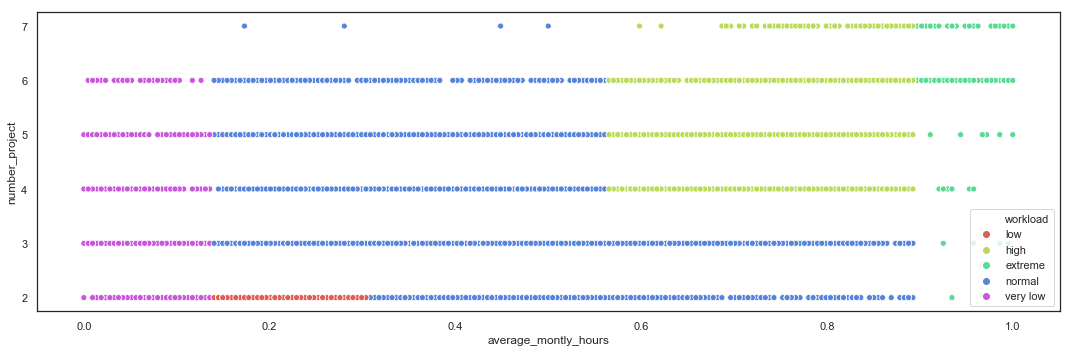

In [83]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr_fe.average_montly_hours,
                y=hr_fe.number_project,
                hue=hr_fe.workload,
                palette = sns.color_palette("hls", 5))
plt.tight_layout()

In [84]:
hr_fe_6 = hr_fe.copy()
hr_fe_6 = onehot_encode(hr_fe_6)
hr_fe_6.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_6.drop('last_evaluation', inplace=True, axis=1)
hr_fe_6.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_6.drop('number_project', inplace=True, axis=1)
hr_fe_6.drop('time_spend_company', inplace=True, axis=1)

In [85]:
X_fe_6, y_fe_6, X_fe_6_train, X_fe_6_test, y_fe_6_train, y_fe_6_test = split_dataset(hr_fe_6, target, split_ratio, seed)
cv_acc(lr, X_fe_6_train, y_fe_6_train, 10, seed)
print()
lr_run(lr, X_fe_6_train, y_fe_6_train, X_fe_6_test, y_fe_6_test)

10-fold cross validation average accuracy: 0.958

Iteration  1 | Accuracy: 0.95
Iteration  2 | Accuracy: 0.94
Iteration  3 | Accuracy: 0.95
Iteration  4 | Accuracy: 0.96
Iteration  5 | Accuracy: 0.97
Iteration  6 | Accuracy: 0.96
Iteration  7 | Accuracy: 0.96
Iteration  8 | Accuracy: 0.97
Iteration  9 | Accuracy: 0.96
Iteration 10 | Accuracy: 0.95

Accuracy on test: 0.959

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3435
           1       0.94      0.88      0.91      1065

   micro avg       0.96      0.96      0.96      4500
   macro avg       0.95      0.93      0.94      4500
weighted avg       0.96      0.96      0.96      4500

Confusion Matrix:
[[3377   58]
 [ 125  940]]

                                       Feature     Coef.
0                                   intercept. -0.766901
1                                Work_accident -1.173201
2                        promotion_last_5years -0.439302
3                      

#### Cluster by Number of Projects and Last Evaluation

Based on the EDA, the employees can be clustered by Project Performance, based on the Number of Projects and Last Evaluation, into 4 categories.

In [86]:
def project_performance_cluster(row):
    if (row['last_evaluation_bin'] == '(0.00, 0.44]'):
        return 'very low'
    if (row['number_project'] <= 2) and (row['last_evaluation_bin'] in ['(0.44, 0.57]']):
        return 'low'
    if (row['number_project'] >= 4) and (row['last_evaluation_bin'] in ['(0.76, 1.00]']):
        return 'high'
    return 'normal'

hr_fe['project_performance'] = hr_fe.apply(lambda row: project_performance_cluster(row), axis=1)
hr_fe.project_performance.value_counts()

normal      8245
high        4589
low         1720
very low     445
Name: project_performance, dtype: int64

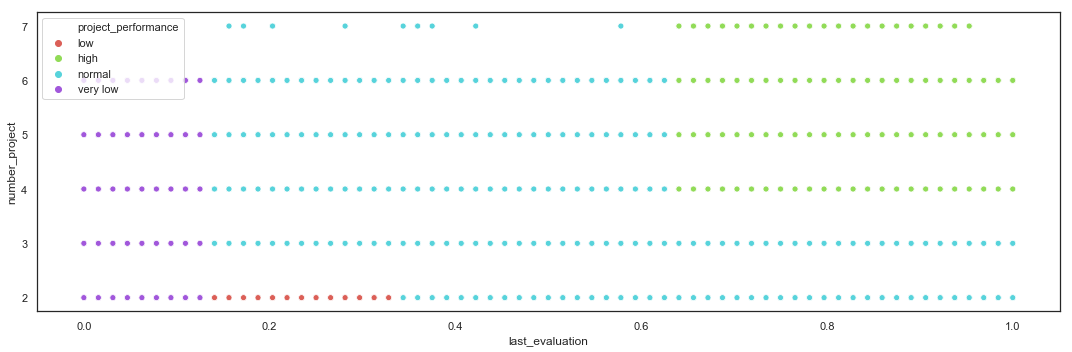

In [87]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr_fe.last_evaluation,
                y=hr_fe.number_project,
                hue=hr_fe.project_performance,
                palette = sns.color_palette("hls", 4))
plt.tight_layout()

In [88]:
hr_fe_7 = hr_fe.copy()
hr_fe_7 = onehot_encode(hr_fe_7)
hr_fe_7.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_7.drop('last_evaluation', inplace=True, axis=1)
hr_fe_7.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_7.drop('number_project', inplace=True, axis=1)
hr_fe_7.drop('time_spend_company', inplace=True, axis=1)

In [89]:
X_fe_7, y_fe_7, X_fe_7_train, X_fe_7_test, y_fe_7_train, y_fe_7_test = split_dataset(hr_fe_7, target, split_ratio, seed)
cv_acc(lr, X_fe_7_train, y_fe_7_train, 10, seed)
print()
lr_run(lr, X_fe_7_train, y_fe_7_train, X_fe_7_test, y_fe_7_test)

10-fold cross validation average accuracy: 0.960

Iteration  1 | Accuracy: 0.96
Iteration  2 | Accuracy: 0.95
Iteration  3 | Accuracy: 0.96
Iteration  4 | Accuracy: 0.96
Iteration  5 | Accuracy: 0.97
Iteration  6 | Accuracy: 0.96
Iteration  7 | Accuracy: 0.96
Iteration  8 | Accuracy: 0.96
Iteration  9 | Accuracy: 0.96
Iteration 10 | Accuracy: 0.95

Accuracy on test: 0.958

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3435
           1       0.93      0.88      0.91      1065

   micro avg       0.96      0.96      0.96      4500
   macro avg       0.95      0.93      0.94      4500
weighted avg       0.96      0.96      0.96      4500

Confusion Matrix:
[[3368   67]
 [ 123  942]]

                                       Feature     Coef.
0                                   intercept. -0.304227
1                                Work_accident -1.223252
2                        promotion_last_5years -0.510657
3                      

#### Cluster by Last Evaluation and Average Monthly Hours

Based on the EDA, the employees can be clustered by Efficiency, based on the Last Evaluation and the Average Monthly Hours, into 4 categories.

In [90]:
def efficiency_cluster(row):
    if (row['last_evaluation_bin'] == '(0.00, 0.44]'):
        return 'very low'
    if (row['average_montly_hours_bin'] in ['(0, 125]']):
        return 'very low'
    if (row['last_evaluation_bin'] in ['(0.44, 0.57]']) and (row['average_montly_hours_bin'] in ['(125, 131]', '(131, 161]']):
        return 'low'
    if (row['last_evaluation_bin'] in ['(0.76, 1.00]']) and (row['average_montly_hours_bin'] in ['(216, 274]', '(274, 287]','(287, 310]']):
        return 'high'
    return 'normal'

hr_fe['efficiency'] = hr_fe.apply(lambda row: efficiency_cluster(row), axis=1)
hr_fe.efficiency.value_counts()

normal      8436
high        3719
low         1994
very low     850
Name: efficiency, dtype: int64

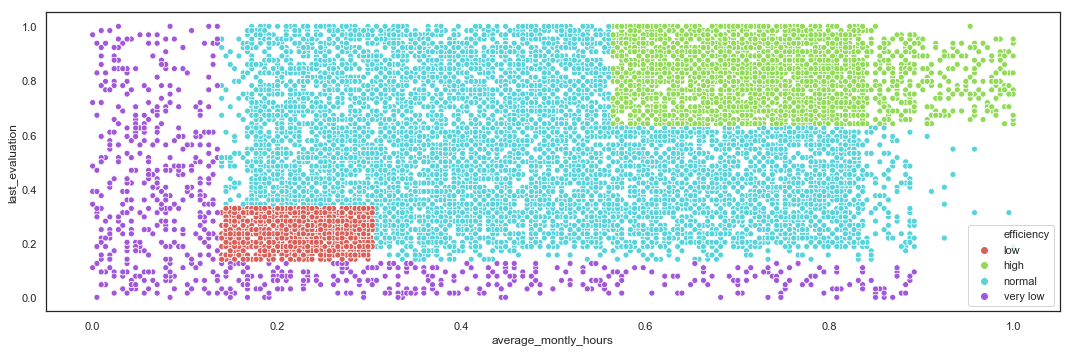

In [91]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr_fe.average_montly_hours,
                y=hr_fe.last_evaluation,
                hue=hr_fe.efficiency,
                palette = sns.color_palette("hls", 4))
plt.tight_layout()

In [92]:
hr_fe_8 = hr_fe.copy()
hr_fe_8 = onehot_encode(hr_fe_8)
hr_fe_8.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_8.drop('last_evaluation', inplace=True, axis=1)
hr_fe_8.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_8.drop('number_project', inplace=True, axis=1)
hr_fe_8.drop('time_spend_company', inplace=True, axis=1)

In [93]:
X_fe_8, y_fe_8, X_fe_8_train, X_fe_8_test, y_fe_8_train, y_fe_8_test = split_dataset(hr_fe_8, target, split_ratio, seed)
cv_acc(lr, X_fe_8_train, y_fe_8_train, 10, seed)
print()
lr_run(lr, X_fe_8_train, y_fe_8_train, X_fe_8_test, y_fe_8_test)

10-fold cross validation average accuracy: 0.960

Iteration  1 | Accuracy: 0.96
Iteration  2 | Accuracy: 0.95
Iteration  3 | Accuracy: 0.96
Iteration  4 | Accuracy: 0.96
Iteration  5 | Accuracy: 0.97
Iteration  6 | Accuracy: 0.96
Iteration  7 | Accuracy: 0.96
Iteration  8 | Accuracy: 0.96
Iteration  9 | Accuracy: 0.96
Iteration 10 | Accuracy: 0.95

Accuracy on test: 0.960

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3435
           1       0.94      0.88      0.91      1065

   micro avg       0.96      0.96      0.96      4500
   macro avg       0.95      0.93      0.94      4500
weighted avg       0.96      0.96      0.96      4500

Confusion Matrix:
[[3377   58]
 [ 124  941]]

                                       Feature     Coef.
0                                   intercept.  0.110311
1                                Work_accident -1.234954
2                        promotion_last_5years -0.581323
3                      

#### Cluster by Last Evaluation and Satisfaction Level

Based on the EDA, the employees can be clustered by Attitude, based on the Last Evaluation and the Satisfaction Level, into 7 categories.

In [94]:
def attitude_cluster(row):
    if (row['last_evaluation_bin'] == '(0.00, 0.44]'):
        return 'low performance'
    if (row['satisfaction_level_bin'] in ['(0.92, 1.00]']):
        return 'very happy'
    if (row['last_evaluation_bin'] in ['(0.76, 1.00]']) and (row['satisfaction_level_bin'] in ['(0.71, 0.92]']):
        return 'happy and high performance'
    if (row['last_evaluation_bin'] in ['(0.44, 0.57]']) and (row['satisfaction_level_bin'] in ['(0.35, 0.46]']):
        return 'unhappy and low performance'
    if (row['satisfaction_level_bin'] in ['(0.00, 0.11]']):
        return 'very unhappy'
    if (row['satisfaction_level_bin'] in ['(0.11, 0.35]','(0.35, 0.46]']):
        return 'unhappy'
    return 'normal'

hr_fe['attitude'] = hr_fe.apply(lambda row: attitude_cluster(row), axis=1)
hr_fe.attitude.value_counts()

normal                         6668
happy and high performance     2553
unhappy and low performance    1635
unhappy                        1474
very happy                     1336
very unhappy                    888
low performance                 445
Name: attitude, dtype: int64

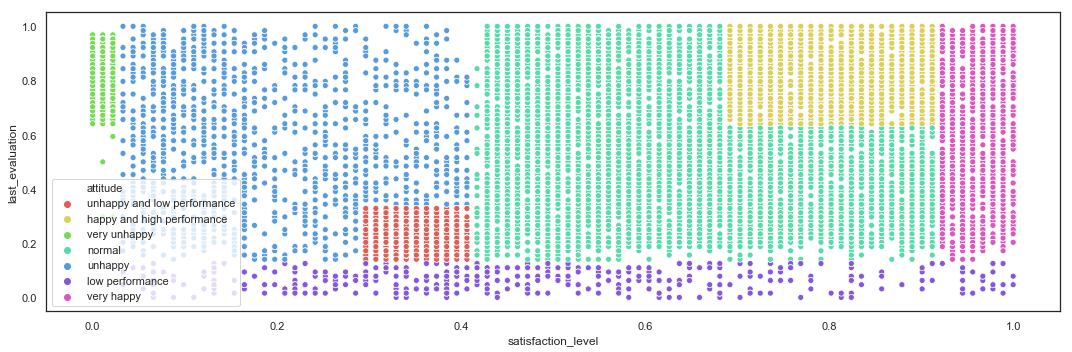

In [95]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr_fe.satisfaction_level,
                y=hr_fe.last_evaluation,
                hue=hr_fe.attitude,
                palette = sns.color_palette("hls", 7))
plt.tight_layout()

In [96]:
hr_fe_9 = hr_fe.copy()
hr_fe_9 = onehot_encode(hr_fe_9)
hr_fe_9.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_9.drop('last_evaluation', inplace=True, axis=1)
hr_fe_9.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_9.drop('number_project', inplace=True, axis=1)
hr_fe_9.drop('time_spend_company', inplace=True, axis=1)

In [97]:
X_fe_9, y_fe_9, X_fe_9_train, X_fe_9_test, y_fe_9_train, y_fe_9_test = split_dataset(hr_fe_9, target, split_ratio, seed)
cv_acc(lr, X_fe_9_train, y_fe_9_train, 10, seed)
print()
lr_run(lr, X_fe_9_train, y_fe_9_train, X_fe_9_test, y_fe_9_test)

10-fold cross validation average accuracy: 0.964

Iteration  1 | Accuracy: 0.96
Iteration  2 | Accuracy: 0.95
Iteration  3 | Accuracy: 0.96
Iteration  4 | Accuracy: 0.97
Iteration  5 | Accuracy: 0.97
Iteration  6 | Accuracy: 0.97
Iteration  7 | Accuracy: 0.97
Iteration  8 | Accuracy: 0.96
Iteration  9 | Accuracy: 0.96
Iteration 10 | Accuracy: 0.96

Accuracy on test: 0.964

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3435
           1       0.94      0.90      0.92      1065

   micro avg       0.96      0.96      0.96      4500
   macro avg       0.96      0.94      0.95      4500
weighted avg       0.96      0.96      0.96      4500

Confusion Matrix:
[[3379   56]
 [ 108  957]]

                                       Feature     Coef.
0                                   intercept.  0.155602
1                                Work_accident -1.143174
2                        promotion_last_5years -0.597843
3                      

#### Removing Unbinned Variables and Encoding New Features

The variables which have been binned are removed from the dataset, and new features are one hot encoded.

In [98]:
hr_fe_encoded = onehot_encode(hr_fe)
hr_fe_encoded.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_encoded.drop('last_evaluation', inplace=True, axis=1)
hr_fe_encoded.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_encoded.drop('number_project', inplace=True, axis=1)
hr_fe_encoded.drop('time_spend_company', inplace=True, axis=1)
df_desc(hr_fe_encoded)

,dtype,NAs,Numerical,Boolean,Categorical
Work_accident,int64,0,False,True,False
left,int64,0,False,True,False
promotion_last_5years,int64,0,False,True,False
salary,int64,0,True,False,False
department_IT,uint8,0,False,True,False
department_RandD,uint8,0,False,True,False
department_accounting,uint8,0,False,True,False
department_hr,uint8,0,False,True,False
department_management,uint8,0,False,True,False
department_marketing,uint8,0,False,True,False


### Features Selection

The dataset resulting from the Feature Engineering phase contains 58 features, with a model reaching the accuracy of 0.964. The Feature Selection phase aims to reduce the number of variables used by the model.

In [99]:
X_fe_encoded, y_fe_encoded, X_fe_encoded_train, X_fe_encoded_test, y_fe_encoded_train, y_fe_encoded_test = split_dataset(hr_fe_encoded, target, split_ratio, seed)
cv_acc(lr, X_fe_encoded_train, y_fe_encoded_train, 10, seed)
print()
lr_run(lr, X_fe_encoded_train, y_fe_encoded_train, X_fe_encoded_test, y_fe_encoded_test)

10-fold cross validation average accuracy: 0.964

Iteration  1 | Accuracy: 0.96
Iteration  2 | Accuracy: 0.95
Iteration  3 | Accuracy: 0.96
Iteration  4 | Accuracy: 0.97
Iteration  5 | Accuracy: 0.97
Iteration  6 | Accuracy: 0.97
Iteration  7 | Accuracy: 0.97
Iteration  8 | Accuracy: 0.96
Iteration  9 | Accuracy: 0.96
Iteration 10 | Accuracy: 0.96

Accuracy on test: 0.964

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3435
           1       0.94      0.90      0.92      1065

   micro avg       0.96      0.96      0.96      4500
   macro avg       0.96      0.94      0.95      4500
weighted avg       0.96      0.96      0.96      4500

Confusion Matrix:
[[3379   56]
 [ 108  957]]

                                       Feature     Coef.
0                                   intercept.  0.155602
1                                Work_accident -1.143174
2                        promotion_last_5years -0.597843
3                      

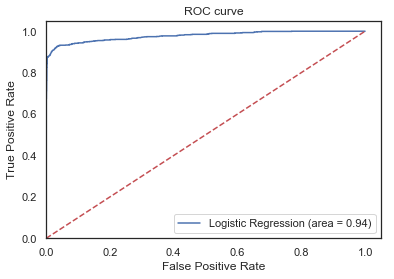

In [100]:
plot_roc(lr, X_fe_encoded_test, y_fe_encoded_test)

The Recursive Feature Elimination (RFE) method is used to select the most relevant features for the model.

In [101]:
accuracies = pd.DataFrame(columns=['features','accuracy', 'cols'])
print('Iterations:')

for i in range(1, len(X_fe_encoded.columns)+1):
    logreg = LogisticRegression(solver='lbfgs', max_iter=250)
    rfe = RFE(logreg, i)
    rfe = rfe.fit(X_fe_encoded, y_fe_encoded.values.ravel())
    
    cols_rfe = list(X_fe_encoded.loc[:, rfe.support_])
    X_rfe_sel = X_fe_encoded_train[cols_rfe]
    X_rfe_test_sel = X_fe_encoded_test[cols_rfe]

    result = logreg.fit(X_rfe_sel, y_fe_encoded_train.values.ravel())
    acc_test = logreg.score(X_rfe_test_sel, y_fe_encoded_test)
    
    accuracies.loc[i] = [i, acc_test, cols_rfe]
    print(i, end='   ')

Iterations:
1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   

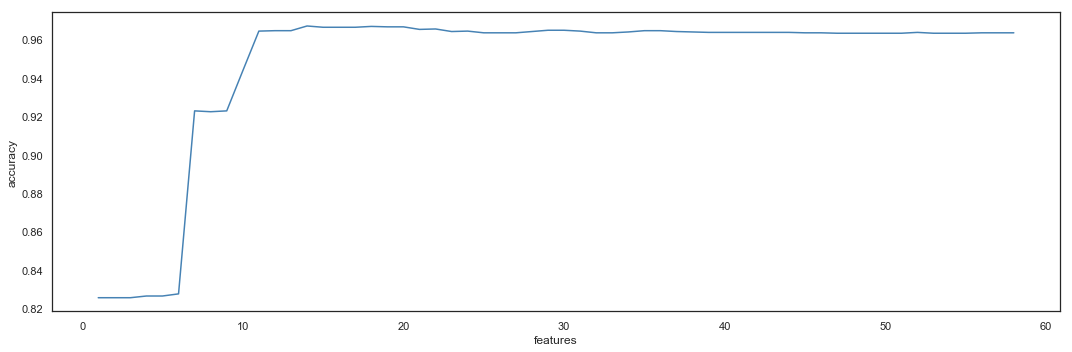

In [102]:
# Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = accuracies['features'],
             y = accuracies['accuracy'],
             color = 'steelblue')#.axes.set_xlim(min(hr.last_evaluation),max(hr.last_evaluation))
plt.tight_layout()

In [103]:
accuracies.nlargest(10, 'accuracy')

,features,accuracy,cols
14,14,0.967111,"[workload_extreme, workload_normal, time_spend..."
18,18,0.966889,"[workload_extreme, workload_normal, time_spend..."
19,19,0.966667,"[workload_extreme, workload_normal, workload_v..."
20,20,0.966667,"[Work_accident, workload_extreme, workload_nor..."
15,15,0.966444,"[workload_extreme, workload_normal, time_spend..."
16,16,0.966444,"[workload_extreme, workload_normal, time_spend..."
17,17,0.966444,"[workload_extreme, workload_normal, time_spend..."
22,22,0.965556,"[Work_accident, workload_extreme, workload_nor..."
21,21,0.965333,"[Work_accident, workload_extreme, workload_nor..."
29,29,0.964889,"[Work_accident, promotion_last_5years, workloa..."


The best model is found with 14 features, for an accuracy of 0.967.

In [104]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

features_rfe = list(hr_fe_encoded)
features_rfe.remove(target)

X_rfe = hr_fe_encoded.loc[:, features_rfe]
y_rfe = hr_fe_encoded.loc[:, target]

logreg = LogisticRegression(solver='lbfgs', max_iter=250)
rfe = RFE(logreg, accuracies.nlargest(1,'accuracy').features.values.ravel()[0])
rfe = rfe.fit(X_rfe, y_rfe)

print(sum(rfe.support_),'selected features:')
for i in list(X_rfe.loc[:, rfe.support_]):
    print(i)

14 selected features:
workload_extreme
workload_normal
time_spend_company_cat_no departure
time_spend_company_cat_very high departure
average_montly_hours_bin_(287, 310]
attitude_normal
attitude_unhappy
attitude_very happy
attitude_very unhappy
number_project_cat_extreme
satisfaction_level_bin_(0.00, 0.11]
satisfaction_level_bin_(0.92, 1.00]
efficiency_low
efficiency_very low


## Final Metric

### Initial Dataset

A final model is tested with the 14 selected features.

In [105]:
cols = list(X_rfe.loc[:, rfe.support_]) + [target]
hr_sel = hr_fe_encoded[cols]

In [106]:
X_sel, y_sel, X_sel_train, X_sel_test, y_sel_train, y_sel_test = split_dataset(hr_sel, target, split_ratio, seed)
cv_acc(lr, X_sel_train, y_sel_train, 10, seed)
print()
lr_run(lr, X_sel_train, y_sel_train, X_sel_test, y_sel_test)

10-fold cross validation average accuracy: 0.964

Iteration  1 | Accuracy: 0.96
Iteration  2 | Accuracy: 0.95
Iteration  3 | Accuracy: 0.96
Iteration  4 | Accuracy: 0.97
Iteration  5 | Accuracy: 0.97
Iteration  6 | Accuracy: 0.96
Iteration  7 | Accuracy: 0.98
Iteration  8 | Accuracy: 0.97
Iteration  9 | Accuracy: 0.96
Iteration 10 | Accuracy: 0.95

Accuracy on test: 0.967

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3435
           1       0.98      0.88      0.93      1065

   micro avg       0.97      0.97      0.97      4500
   macro avg       0.97      0.94      0.95      4500
weighted avg       0.97      0.97      0.97      4500

Confusion Matrix:
[[3419   16]
 [ 132  933]]

                                       Feature     Coef.
0                                   intercept. -0.375952
1                             workload_extreme  2.245120
2                              workload_normal -2.183617
3          time_spend_c

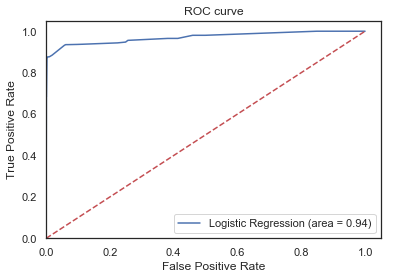

In [107]:
plot_roc(lr, X_sel_test, y_sel_test)

The model returns the accuracy of 0.967. The recall for employees who left the company now reaches 88%, which will allow the management to better predict which employees have a high probability to leave.

### Over Sampling with SMOTE

To ensure the model is not biased by the imbalanced proportions of the variable `left`, the dataset is enriched by synthetic samples using the Synthetic Minority Oversampling Technique (SMOTE). Only the train set is over-sampled, to ensure it doesn't get polluted by the test set.

In [108]:
# Install the imbalanced-learn package with this command:
# conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_smote, y_smote, X_smote_train, X_smote_test, y_smote_train, y_smote_test = split_dataset(hr_fe_encoded, target, split_ratio, seed)
columns = X_smote_train.columns

os_data_X,os_data_y = os.fit_sample(X_smote_train, y_smote_train.values.ravel())
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['left'])
# we can Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of 'stayed' in oversampled data",len(os_data_y[os_data_y['left']==0]))
print("Number of 'left'",len(os_data_y[os_data_y['left']==1]))
print("Proportion of 'stayed' data in oversampled data is ",len(os_data_y[os_data_y['left']==0])/len(os_data_X))
print("Proportion of 'left' data in oversampled data is ",len(os_data_y[os_data_y['left']==1])/len(os_data_X))

Length of oversampled data is  15986
Number of 'stayed' in oversampled data 7993
Number of 'left' 7993
Proportion of 'stayed' data in oversampled data is  0.5
Proportion of 'left' data in oversampled data is  0.5


In [109]:
cv_acc(lr, os_data_X, os_data_y, 10, seed)
print()
lr_run(lr, os_data_X, os_data_y, X_smote_test, y_smote_test)

10-fold cross validation average accuracy: 0.963

Iteration  1 | Accuracy: 0.96
Iteration  2 | Accuracy: 0.95
Iteration  3 | Accuracy: 0.96
Iteration  4 | Accuracy: 0.95
Iteration  5 | Accuracy: 0.96
Iteration  6 | Accuracy: 0.95
Iteration  7 | Accuracy: 0.97
Iteration  8 | Accuracy: 0.97
Iteration  9 | Accuracy: 0.97
Iteration 10 | Accuracy: 0.98

Accuracy on test: 0.957

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3435
           1       0.90      0.92      0.91      1065

   micro avg       0.96      0.96      0.96      4500
   macro avg       0.94      0.95      0.94      4500
weighted avg       0.96      0.96      0.96      4500

Confusion Matrix:
[[3321  114]
 [  81  984]]

                                       Feature      Coef.
0                                   intercept.  17.979973
1                                Work_accident  -1.539814
2                        promotion_last_5years  -0.873542
3                  

The accuracy is consistent with the initial dataset. The RFE algorithm is used to find the most relevant features.

In [110]:
accuracies_smote = pd.DataFrame(columns=['features','accuracy', 'cols'])
print('Iterations:')

for i in range(1, len(os_data_X.columns)+1):
    logreg = LogisticRegression(solver='lbfgs', max_iter=250)
    rfe_smote = RFE(logreg, i)
    rfe_smote = rfe_smote.fit(os_data_X, os_data_y.values.ravel())
    
    cols_rfe_smote = list(os_data_X.loc[:, rfe_smote.support_])
    os_data_X_sel = os_data_X[cols_rfe_smote]
    X_smote_test_sel = X_smote_test[cols_rfe_smote]

    result = logreg.fit(os_data_X_sel, os_data_y.values.ravel())
    acc_test = logreg.score(X_smote_test_sel, y_smote_test)
    
    accuracies_smote.loc[i] = [i, acc_test, cols_rfe_smote]
    print(i, end='   ')

Iterations:
1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   

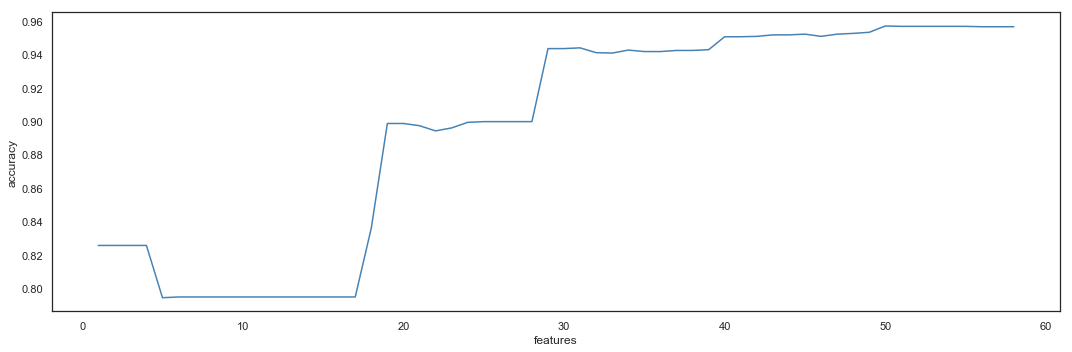

In [111]:
# Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = accuracies_smote['features'],
             y = accuracies_smote['accuracy'],
             color = 'steelblue')#.axes.set_xlim(min(hr.last_evaluation),max(hr.last_evaluation))
plt.tight_layout()

In [112]:
accuracies_smote.nlargest(10, 'accuracy')

,features,accuracy,cols
50,50,0.957111,"[Work_accident, promotion_last_5years, salary,..."
51,51,0.956889,"[Work_accident, promotion_last_5years, salary,..."
52,52,0.956889,"[Work_accident, promotion_last_5years, salary,..."
53,53,0.956889,"[Work_accident, promotion_last_5years, salary,..."
54,54,0.956889,"[Work_accident, promotion_last_5years, salary,..."
55,55,0.956889,"[Work_accident, promotion_last_5years, salary,..."
56,56,0.956667,"[Work_accident, promotion_last_5years, salary,..."
57,57,0.956667,"[Work_accident, promotion_last_5years, salary,..."
58,58,0.956667,"[Work_accident, promotion_last_5years, salary,..."
49,49,0.953333,"[Work_accident, promotion_last_5years, departm..."


The best model is found with 50 features, for an accuracy of 0.957.

In [113]:
logreg = LogisticRegression(solver='lbfgs', max_iter=250)
rfe_smote = RFE(logreg, accuracies_smote.nlargest(1,'accuracy').features.values.ravel()[0])
rfe_smote = rfe_smote.fit(os_data_X, os_data_y.values.ravel())

print(sum(rfe_smote.support_),'selected features:')
for i in list(os_data_X.loc[:, rfe_smote.support_]):
    print(i)

50 selected features:
Work_accident
promotion_last_5years
salary
department_IT
department_RandD
department_accounting
department_hr
department_management
department_marketing
department_product_mng
department_sales
department_support
department_technical
workload_extreme
workload_high
workload_normal
workload_very low
time_spend_company_cat_high departure
time_spend_company_cat_low departure
time_spend_company_cat_no departure
average_montly_hours_bin_(0, 125]
average_montly_hours_bin_(125, 131]
average_montly_hours_bin_(131, 161]
average_montly_hours_bin_(161, 216]
average_montly_hours_bin_(216, 274]
average_montly_hours_bin_(274, 287]
average_montly_hours_bin_(287, 310]
last_evaluation_bin_(0.00, 0.44]
last_evaluation_bin_(0.44, 0.57]
last_evaluation_bin_(0.57, 0.76]
last_evaluation_bin_(0.76, 1.00]
attitude_low performance
attitude_normal
attitude_unhappy
attitude_very happy
attitude_very unhappy
project_performance_normal
project_performance_very low
number_project_cat_extreme
numb

The selected columns are really numerous compared to the initial dataset. However, the model is built to check its metrics.

In [114]:
cols_smote = list(os_data_X.loc[:, rfe_smote.support_])
os_data_X_sel = os_data_X[cols_smote]
X_smote_test_sel = X_smote_test[cols_smote]

In [115]:
cv_acc(lr, os_data_X_sel, os_data_y, 10, seed)
print()
lr_run(lr, os_data_X_sel, os_data_y, X_smote_test_sel, y_smote_test)

10-fold cross validation average accuracy: 0.962

Iteration  1 | Accuracy: 0.96
Iteration  2 | Accuracy: 0.95
Iteration  3 | Accuracy: 0.96
Iteration  4 | Accuracy: 0.95
Iteration  5 | Accuracy: 0.96
Iteration  6 | Accuracy: 0.95
Iteration  7 | Accuracy: 0.97
Iteration  8 | Accuracy: 0.97
Iteration  9 | Accuracy: 0.97
Iteration 10 | Accuracy: 0.97

Accuracy on test: 0.957

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3435
           1       0.90      0.92      0.91      1065

   micro avg       0.96      0.96      0.96      4500
   macro avg       0.94      0.95      0.94      4500
weighted avg       0.96      0.96      0.96      4500

Confusion Matrix:
[[3322  113]
 [  80  985]]

                                  Feature      Coef.
0                              intercept.  17.376456
1                           Work_accident  -1.540492
2                   promotion_last_5years  -0.877758
3                                  sala

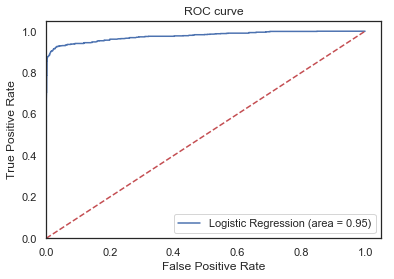

In [116]:
plot_roc(lr, X_smote_test_sel, y_smote_test)

The model run on over-sampled dataset has an accuracy really closed to the model run on the original dataset. We can conclude that the imbalanced proportions of the target in our dataset didn't insert bias in our model.  

However, as more variables are necessary to achieve an equivalent accuracy, it indicates that the feature selection might have been biased by our feature construction. In fact, the binned features were built to fit the data, and allow to remove many features from our initial model. But this technique makes our model over-fit the data, reducing its chances to achieve the same accuracy with a new dataset. This might explain why the Recursive Feature Elimination cannot select the same features:

In [117]:
list_features = pd.DataFrame({'Initial':sorted(list(accuracies.loc[accuracies.features == 14]['cols'])[0]),
                          'SMOTE':sorted(list(accuracies_smote.loc[accuracies_smote.features == 14]['cols'])[0])})
list_features

,Initial,SMOTE
0,attitude_normal,attitude_normal
1,attitude_unhappy,attitude_very happy
2,attitude_very happy,"average_montly_hours_bin_(287, 310]"
3,attitude_very unhappy,department_IT
4,"average_montly_hours_bin_(287, 310]",department_RandD
5,efficiency_low,department_accounting
6,efficiency_very low,department_management
7,number_project_cat_extreme,department_marketing
8,"satisfaction_level_bin_(0.00, 0.11]",department_sales
9,"satisfaction_level_bin_(0.92, 1.00]",department_technical


However, the model can be tested using the exact same selection of columns than the ones selected by the initial RFE.

In [118]:
cols_1 = cols.copy()
cols_1.remove('left')
print(cols_1)
os_data_X_sel_1 = os_data_X[cols_1]
X_smote_test_sel_1 = X_smote_test[cols_1]

['workload_extreme', 'workload_normal', 'time_spend_company_cat_no departure', 'time_spend_company_cat_very high departure', 'average_montly_hours_bin_(287, 310]', 'attitude_normal', 'attitude_unhappy', 'attitude_very happy', 'attitude_very unhappy', 'number_project_cat_extreme', 'satisfaction_level_bin_(0.00, 0.11]', 'satisfaction_level_bin_(0.92, 1.00]', 'efficiency_low', 'efficiency_very low']


In [119]:
cv_acc(lr, os_data_X_sel_1, os_data_y, 10, seed)
print()
lr_run(lr, os_data_X_sel_1, os_data_y, X_smote_test_sel_1, y_smote_test)

10-fold cross validation average accuracy: 0.937

Iteration  1 | Accuracy: 0.95
Iteration  2 | Accuracy: 0.93
Iteration  3 | Accuracy: 0.95
Iteration  4 | Accuracy: 0.93
Iteration  5 | Accuracy: 0.94
Iteration  6 | Accuracy: 0.94
Iteration  7 | Accuracy: 0.94
Iteration  8 | Accuracy: 0.93
Iteration  9 | Accuracy: 0.93
Iteration 10 | Accuracy: 0.93

Accuracy on test: 0.938

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3435
           1       0.83      0.94      0.88      1065

   micro avg       0.94      0.94      0.94      4500
   macro avg       0.90      0.94      0.92      4500
weighted avg       0.94      0.94      0.94      4500

Confusion Matrix:
[[3224  211]
 [  69  996]]

                                       Feature     Coef.
0                                   intercept.  0.698509
1                             workload_extreme  1.946942
2                              workload_normal -1.989443
3          time_spend_c

The resulting accuracy is still really good, which confirms that the initial model didn't have bias due to the imbalance of the dataset.

The high accuracy is anyway driven by the binned features tailored to the dataset. If they work really well for this data, it might not be the case for another dataset. The features should instead be set using standard binning approach, which wouldn't fit as well the data but which would be adaptable to any dataset. That solution would be recommended if the model has to be run in production.

***

*Ashley O'Mahony | [ashleyomahony.com](http://ashleyomahony.com) | February 2019*  

***